# Data for Good: predicting suicidal behavior likelihood among Reddit users using Deep Learning (Part 1)

*Deep Learning and Reinforcement Learning (part of IBM Machine Learning Professional Certificate) - Course Project.*

>*No one is useless in this world who lightens the burdens of another.*  
― **Charles Dickens**

<img src='https://www.discover-norway.no/upload/images/-development/header/desktop/kul_munch/edvard%20munch%20the%20scream%201893_munchmmuseet.jpg'></img>

## Table of contents (Part 1)
1. [Introduction: the project](#project)  
2. [Methodology](#methodology)  
3. [Data Understanding](#data)  
  3.1. [Data Cleaning](#cleaning)  
  3.2. [Exploratory Data Analysis](#eda)
4. [Data Preparation](#preparation)  
  4.1. [Drop non-relevant features](#features)  
  4.2. [Remove the stop words](#stopwords)  
  4.3. [Split the dataset into training and testing sets](#split)  
  4.4. [Tokenize the text](#tokenize)  
  4.5. [Pad the sequences](#padding)  
5. [Model Development: Recurrent Neural Networks](#model)  
  5.1. [Learn word embeddings from scratch](#scratch)

## 1. Introduction: the project <a name=project></a>

Data for good means using Data Science and Machine Learning tools outside of the for-profit sector, to help Non-profits, NGOs, or any other organization or individual, leverage the power of data for good causes and to improve the life of others.

There are many ways to use the power of Data Science for good: data can be used to solve social issues, environmental problems, enhance community security as well as support people in need.  
Nowadays, the use of Social Media, forums or news aggregation websites is massively widespread, with people sharing plenty of details about their life. Some people also use internet to share very serious issues, as a cry for help.  
**The scope of this project is to identify, amongst users in an online community, people at risk of self-harm or suicide, so that actions can be undertaken to provide Targeted Suicide Intervention in a timely-fashioned and sustained manner.**

To achieve the project purpose I'll analyze user-generated content from a social discussion website (Reddit), about mental health issues, to ultimately predict if users are struggling with severe mental problems and therefore assessing whether they are at risk (so that support can be provided) or not.

## 2. Methodology <a name=methodology></a>

I'll follow a **predictive analytic approach** aimed **to correctly classify users**, based on their posts' content, into the **correct category**:
1. **Not at risk (Negative Class):** users don't strugggle with servere mental issues and they are not at risk of self-harm.
2. **At risk (Positive Class):** users struggle with mental health issues, they may be dealing with suicidal thoughts and/or suicidal behavior, or have altready tried to commit suicide.

To deliver reliable results, I'll follow the <a href='https://en.wikipedia.org/wiki/Cross-industry_standard_process_for_data_mining'>**Cross-Industry Standard Process for Data Mining (CRISP-DM)**</a>, which consists of the following steps:  
1. **Project Understanding** (see the Introduction section).  
2. **Data Understanding**: data cleaning and exploratory data analysis.  
3. **Data Preparation**: transform the data into a usable dataset for modeling.  
4. **Modeling**: I 'll build at least 3 Deep Learning models, using the Recurrent Neural Network class.  

Since we are dealing with Natural Langage Processing (NLP), I have to "trasform" words in a way that they can be fed through a Neural Network, that is representing words with numbers. This is called **Word Embedding:** a representation of a word as a numeric vector that encodes the meaning of that word. Words that have similar meaning are (or should be) closer in the vector space. When working with word embeddings, there are mainly 2 options: learn your own embeddings, using the data you have, or apply **Transfer Learning** concepts, that is using word embeddings that have been pre-trained on large datasets, saved, and can be re-used for solving other tasks.  
For this project, I'll build and train 3 models:  
- Learning the Word Embeddings from scratch, using the training data of my dataset  
- Using pre-trained <a href='https://nlp.stanford.edu/projects/glove/'>GloVe Word Embeddings</a>  
- Using pre-trained <a href='https://code.google.com/archive/p/word2vec/'>Google News Word2Vec Word Embeddings</a>  
 5. **Evaluation**: models' performance will be compared and evaluated using the following metrics: Accuracy Score, Confusion Matrix, Classification Report, F1-Score, ROC and Precision-Recall curves.

## 3. Data Understanding <a name=data></a>

In [1]:
import pandas as pd
from random import randrange, seed

In [2]:
ds = pd.read_csv(r'500_Reddit_users_posts_labels.csv')
data = ds.copy()
data.head()

User                                               Post       Label
0  user-0  ['Its not a viable option, and youll be leavin...  Supportive
1  user-1  ['It can be hard to appreciate the notion that...    Ideation
2  user-2  ['Hi, so last night i was sitting on the ledge...    Behavior
3  user-3  ['I tried to kill my self once and failed badl...     Attempt
4  user-4  ['Hi NEM3030. What sorts of things do you enjo...    Ideation

In [3]:
data.tail()

User                                               Post       Label
495  user-495  ['Its not the end, it just feels that way. Or ...  Supportive
496  user-496  ['It was a skype call, but she ended it and Ve...   Indicator
497  user-497  ['That sounds really weird.Maybe you were Dist...  Supportive
498  user-498  ['Dont know there as dumb as it sounds I feel ...     Attempt
499  user-499  ['&gt;It gets better, trust me.Ive spent long ...    Behavior

In [4]:
print('Number of tuples in the dataset : {}.\nNumber of attributes in the dataset: {}.'.format(data.shape[0], data.shape[1]))

Number of tuples in the dataset : 500.
Number of attributes in the dataset: 3.


In [5]:
col = []
for a in data.columns:
    col.append(a)

print("Name of the attributes:", col)

Name of the attributes: ['User', 'Post', 'Label']


In [6]:
print("Data Types:")
data.dtypes

Data Types:


User     object
Post     object
Label    object
dtype: object

In [7]:
print('Number of unique values in column "{}": {}'.format(data.columns[0], data['User'].nunique()))
print('Number of unique values in column "{}": {}'.format(data.columns[1], data['Post'].nunique()))
print('Number of unique values in column "{}": {}'.format(data.columns[2], data['Label'].nunique()))

Number of unique values in column "User": 500
Number of unique values in column "Post": 500
Number of unique values in column "Label": 5


In [8]:
print('Unique values in column "Label":',sorted(data['Label'].unique()))

Unique values in column "Label": ['Attempt', 'Behavior', 'Ideation', 'Indicator', 'Supportive']


Dataset source: <a href='https://www.kaggle.com/datasets/thedevastator/c-ssrs-labeled-suicidality-in-500-anonymized-red'>www.kaggle.com</a>.  

The dataset includes posts from 500 redditors that have discussed topics about suicide and mental health illness like depression. The posts have been classified into 5 categories, following a modified version of the guidelines outlined in the Columbia Suicide Severity Rating Scale (C-SSRS).

The dataset contains 3 columns for 500 observations, where each column contains text-type data. Columns are as follows:
- **User:** a string of characters representing an anonymized Reddit user ID.
- **Post:** the text from the user's posts (without no personal information revealed).
- **Label:** the class the users has been assigned to, based on their posts' content. Classes are as follows:
   - Attempt
   - Behavior
   - Ideation
   - Indicator
   - Supportive

To understand the classes a bit better, I'm going to visualize posts from one random user per each class.  
During the EDA stage, we'll eventually define the classes' meaning and group users in 2 macro-classes: "At risk" and "Not at risk".

In [9]:
print('\033[1m'+'Posts from a user labelled as "Attempt":'+'\033[0m')
seed(14)
print(data[data.Label == 'Attempt']['User'].iloc[randrange(data[data.Label == 'Attempt'].shape[0])]+':')
seed(14)
print(data[data.Label == 'Attempt']['Post'].iloc[randrange(data[data.Label == 'Attempt'].shape[0])])

Posts from a user labelled as "Attempt":
user-46:
['There is nothing else to share. Nothing can change now. No matter what I share or what people tell me, my life will be the same. I guess you could say its time I check out a bit early', 'I really do hope you help your students. All the teachers fucking avoided me because I was socially awkward and didnt know hope to act. Just make one promise to me and that is no matter how bad a student is, or how much they dont appreciate your help then just stay with them. I wish I fucking had that rather than abuse I got. Even if I graduate from something. Study something I WILL NEVER HAVE THE LIFE I WANT. before you say that I should have other goals of value other things dont bother. Some of us want to be doctors,engineers,teachers,athletes. Just because I want to be rich doesnt mean Im selfish. We all want to help everyone in the world. but sometimes we cant. We just focus on helping one person, even if that person is ourself. I cant be saved. 

In [10]:
print('\033[1m'+'Posts from a user labelled as "Behavior":'+'\033[0m')
seed(8)
print(data[data.Label == 'Behavior']['User'].iloc[randrange(data[data.Label == 'Behavior'].shape[0])]+':')
seed(8)
print(data[data.Label == 'Behavior']['Post'].iloc[randrange(data[data.Label == 'Behavior'].shape[0])])

Posts from a user labelled as "Behavior":
user-134:
['Thank you so much for this.', 'I dont know what to say. I dont even know how to feel or if my emotions are justified. I know that my dad has a right to be frustrated with me. After I lost my job, the bills started to pill on and now theyre hovering over my head like a storm cloud.But its not the fact that Ive lost my job and have no room to my own thats bothering me right now. Its the hurtful things he said to me this morning.Now Im too Anxiety to sleep, I feel worse about myself than I have in the past few weeks. The last time my father hugged me or showed any visible/palpable affection towards me was when I graduated high school five years ago. I had to graduate for him to tell me he was proud of me and that he loved me.Most of the time its static apathy or blatant resentment. There is no warmth there. Im always on eggshells around him. Which hurts even worse because I used to be a real daddys girl. We used to be close, when I was

In [11]:
print('\033[1m'+'Posts from a user labelled as "Ideation":'+'\033[0m')
seed(7)
print(data[data.Label == 'Ideation']['User'].iloc[randrange(data[data.Label == 'Ideation'].shape[0])]+':')
seed(7)
print(data[data.Label == 'Ideation']['Post'].iloc[randrange(data[data.Label == 'Ideation'].shape[0])])

Posts from a user labelled as "Ideation":
user-227:
['possibly!sorry about the empty post. its sort of a hard subject to just jump into.basically, ive been constantly Delusional disorder at my uni for the past couple of months, and it has been extremely detrimental to my mental health. its especially bad when doing anything online when i most feel like im being spied on, making it extremely difficult to reach out for help in any way. i had to stop talking with one of my good friends online because the Delusional disorder was so bad.the whole situation makes me want to dissapear because of how much it makes me feel isolated with no chance that things will get better. ']


In [12]:
print('\033[1m'+'Posts from a user labelled as "Indicator":'+'\033[0m')
seed(15)
print(data[data.Label == 'Indicator']['User'].iloc[randrange(data[data.Label == 'Indicator'].shape[0])]+':')
seed(15)
print(data[data.Label == 'Indicator']['Post'].iloc[randrange(data[data.Label == 'Indicator'].shape[0])])

Posts from a user labelled as "Indicator":
user-171:
['Ironically social work. I never really had fun with his friends, he was just emotionally stable but really really really lazy. Our friends were mostly people from his program in university, so I never really had too much to talk to them about. I feel so guilty that I dont feel sad that hes gone. I just feel so lonely all the time now. ', 'Still got another two years to go haha. ', 'Yeah I think we can do it, we totally got this! But it is *hard* to be normal. I spend so much time and energy trying to make it appear that my life is groovy and drama free that everything I do these days feels like a lie. How does temporary academic leave work? Thanks so much for the reply.']


In [13]:
print('\033[1m'+'Posts from a user labelled as "Supportive":'+'\033[0m')
seed(2)
print(data[data.Label == 'Supportive']['User'].iloc[randrange(data[data.Label == 'Supportive'].shape[0])]+':')
seed(2)
print(data[data.Label == 'Supportive']['Post'].iloc[randrange(data[data.Label == 'Supportive'].shape[0])])

Posts from a user labelled as "Supportive":
user-29:
['Then maybe returningt there might be the first step. You should be w/ the family of your choice, not w/ people who clearly dont want the best for you. You should take care of yourself for a while and while doing that maybe also put some distance between you and that girl - it might help you to put things into perspective. Stay strong!', 'No matter whether you believe in fate or God or anything: that misfiring gun was a SIGN and Im really thankful for it. I hope you can use this extreme experience to your advantage!', 'Scumbag brain... Sees something beautiful and uplifting: yanks the tear ducts wiiide open...', 'Please dont feel guilty. You have a disease and it is so strong that even your partners love cant seem to stop it. Its not your fault and its not an unusual thing to happen. Maybe its really for the best if you outsource the job of taking care of you. That could take the feeling of guilt off your shoulders and also relieve 

After a look at one post per each class, we can start identifying each class' meanings and their characteristics:
- **Attempt:** users have already attempted suicide or actively planning to do it.  
- **Behavior:** users struggle with mental issues, like panic attacks, have suicidal thoughts, and at times practice self-harming behavior.
- **Ideation:** users are going through rough paths, they suffer from mental issues like delusional disorder, they wish to die or disappear, and they have little hope things get better.
- **Indicator:** users show some very light signs of distress like guilt, sadness, or loneliness.
- **Supportive:** users show empathy and support people's feeling, discouraging them from suicidal ideas.

### 3.1. Data Cleaning <a name=cleaning></a>

In [14]:
#import needed libraries for data cleaning
import string
import re

#### Duplicates

In [15]:
# Looking for duplicates
print('Number of duplicate observations in the dataset:',data.duplicated().sum())

Number of duplicate observations in the dataset: 0


#### Missing Values

In [16]:
# Looking for missing values
for col in data.columns:
    print('Number of missing values in the attribute {}: {}'.format(col, data[col].isnull().sum()))

Number of missing values in the attribute User: 0
Number of missing values in the attribute Post: 0
Number of missing values in the attribute Label: 0


#### Apply standard format: delete punctuation, lower case all words, and remove leading, trailing and consecutive  white spaces

In [17]:
#visualize random post before cleaning
seed(6)
data.iloc[randrange(500)]

User                                              user-406
Post     ['Ive tried that. Im Exhaustion of trying and ...
Label                                             Ideation
Name: 406, dtype: object

---

In [18]:
#1. Remove punctuation: visualize random post with punctuation
seed(25)
data.iloc[randrange(500)]['Post']

"['Dont feel guilty. Better than doing nothing, get someone(his family or a friend) to show him that he is cared for. If you get a chance you could go personally and help him. For now keep him encouraged. Try to cheer him up and distract him from these thoughts.', 'I understand how you feel. I also get such thoughts. If you need a friend, Ill be there for you(you can PM me). Dont waste yourself. You are a blessing to this world.Your family will feel Tired sad. BTW, its better you try taking that anti-depressing medication. Please throw away the gun. ', 'True. Everyone has a guardian angel. ']"

In [19]:
#Remove punctuation
data["Post"] = data['Post'].apply(lambda x: re.sub('['+string.punctuation+']', ' ', x))

In [20]:
#visualize post after removing punctuation
seed(25)
data.iloc[randrange(500)]['Post']

'  Dont feel guilty  Better than doing nothing  get someone his family or a friend  to show him that he is cared for  If you get a chance you could go personally and help him  For now keep him encouraged  Try to cheer him up and distract him from these thoughts     I understand how you feel  I also get such thoughts  If you need a friend  Ill be there for you you can PM me   Dont waste yourself  You are a blessing to this world Your family will feel Tired sad  BTW  its better you try taking that anti depressing medication  Please throw away the gun      True  Everyone has a guardian angel    '

---

In [21]:
# 2. lower case all words. Visualize random posts
seed(34)
data.iloc[randrange(500)]['Post']

'  Man  I know what you mean Its that proverbial downward spiral to death  Were supposed to just make it happen  life  somehow  someway   I guess  I dont even know anymore  none of this makes sense or is or was fun in the slightest ever   '

In [22]:
#lower case the words
data['Post'] = data['Post'].apply(lambda x: x.lower())

In [23]:
#visualize post after lower case the words
seed(34)
data.iloc[randrange(500)]['Post']

'  man  i know what you mean its that proverbial downward spiral to death  were supposed to just make it happen  life  somehow  someway   i guess  i dont even know anymore  none of this makes sense or is or was fun in the slightest ever   '

---

In [24]:
# 3. remove consecutive white spaces. Visualize posts (up to 35 consecutive white spaces)
pd.set_option('display.max_colwidth', None)
data[data['Post'].str.contains('                                   ')].Post

268      thats a when  is there a detailed why  can you give an analysis why you think these things im interested in hearing you out on this man     shit yeah man  i as never into mt g  but i did play l5r for a bit  mt g was too much bean counting for me play any rpgs     just wanted to second the foundation thing  i am a genital diseases  male that has had acne very long term  ive had a small bottle of liquid foundation picked for me by an ex for so long  it really helps those red marks look hyperactive behavior they are way further along the healing path than they really are  use the back of your ache wrists to pick the color  if you use just a couple of drops it can make a world of difference and nobody knows when you do get to talk to a dermatologist  mention you want to look into  isotretinoin  http   en wikipedia org wiki isotretinoin   it is a god damn poison but it cleared me up near instantly on half dose  twice  it gave me a mental relief hyperactive behavior you wouldnt beli

In [25]:
#delete consecutive white spaces (up to 35 consecutive white spaces)
cws = '                                   '
while len(cws) > 1:
    data['Post'] = data['Post'].str.replace(cws, cws[:-1])
    cws = cws[:-1]

In [26]:
# Visualize post after removing consecutive white spaces.
data.loc[268].Post

' thats a when is there a detailed why can you give an analysis why you think these things im interested in hearing you out on this man shit yeah man i as never into mt g but i did play l5r for a bit mt g was too much bean counting for me play any rpgs just wanted to second the foundation thing i am a genital diseases male that has had acne very long term ive had a small bottle of liquid foundation picked for me by an ex for so long it really helps those red marks look hyperactive behavior they are way further along the healing path than they really are use the back of your ache wrists to pick the color if you use just a couple of drops it can make a world of difference and nobody knows when you do get to talk to a dermatologist mention you want to look into isotretinoin http en wikipedia org wiki isotretinoin it is a god damn poison but it cleared me up near instantly on half dose twice it gave me a mental relief hyperactive behavior you wouldnt believe dont kill yourself save up for 

---

In [27]:
# 4. remove leading and trailing white spaces. Visualize random posts
seed(666)
data.iloc[randrange(500)]['Post']

' thanks for your help yeah i believe he is willing to go by himself but i would still like to go if nothing else just to support and be there for him hes a real popular guy one of the big dicks on campus politically wise and yet hes only this open to me i dont even think that im his best friend so since hes only open to me i think thats reason enough for me to be there ill probably make it more comfortable for him basically the only part im stuck on is whether or not i tell the docs he actually tried to kill himself instead of simply cutting much love thanks for the genuine reply '

In [28]:
#remove leading and trailing white spaces
data.Post = data.Post.apply(lambda x: x.strip())

In [29]:
#visualize post after removing leading and trailing white spaces
seed(666)
data.iloc[randrange(500)]['Post']

'thanks for your help yeah i believe he is willing to go by himself but i would still like to go if nothing else just to support and be there for him hes a real popular guy one of the big dicks on campus politically wise and yet hes only this open to me i dont even think that im his best friend so since hes only open to me i think thats reason enough for me to be there ill probably make it more comfortable for him basically the only part im stuck on is whether or not i tell the docs he actually tried to kill himself instead of simply cutting much love thanks for the genuine reply'

---

In [30]:
#visualize the posts from user 406 after cleaning
seed(6)
data.iloc[randrange(500)].Post

'ive tried that im exhaustion of trying and falling at everything im looking att gun and trying to figure why not to do it heh even reddit cant give me a reason to keep on going'

### 3.2. Exploratory Data Analysis <a name=eda></a>

In [31]:
#pip install nltk

In [32]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
pd.set_option('display.max_colwidth', 50)
import collections

In [33]:
data.describe()

User                                               Post     Label
count      500                                                500       500
unique     500                                                500         5
top     user-0  its not a viable option and youll be leaving y...  Ideation
freq         1                                                  1       171

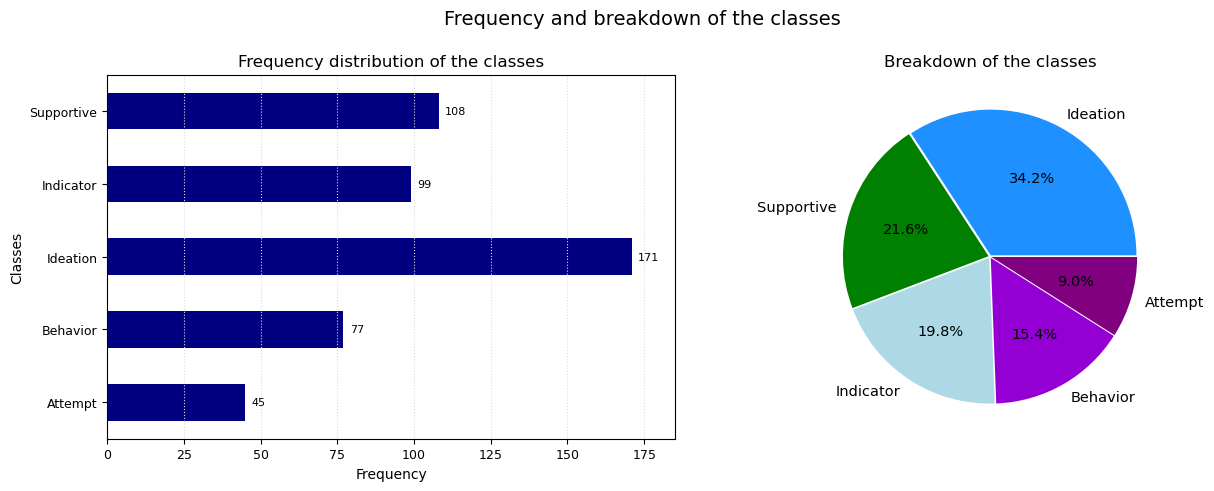

In [34]:
class_freq = data.groupby(['Label']).size()

fig = plt.figure(figsize=(13,5))
barchart = fig.add_subplot(1,2,1) 
piechart = fig.add_subplot(1,2,2)

class_freq.plot(x=class_freq.index, y=class_freq, kind='barh', color='navy', xlim=(0,185), ax=barchart)
for i in barchart.patches:
    barchart.annotate(i.get_width(), # get the frequency of the variable categories
                      xy = (i.get_width()+2, i.get_y() + i.get_height()-0.25), # set the coordinates for each label
                      ha='left', # set the horizontal alignment
                      va='center', # set the vertical alignment
                      fontsize=8) # set the font size

barchart.set_title('Frequency distribution of the classes', fontsize=12)
barchart.set_xlabel("Frequency", fontsize=10)
barchart.set_ylabel('Classes', fontsize=10)
barchart.set_xticks(range(0,180,25)) 
barchart.set_xticklabels(range(0,180,25), fontsize=9)
barchart.set_yticklabels(class_freq.index, fontsize=9)
barchart.grid(True, axis='x', color='gainsboro', ls= ':', linewidth=0.8)

data['Label'].value_counts().plot(kind='pie',
                                  #figsize=(3,3), # set axis lengths
                                  autopct='%1.1f%%',
                                  startangle=0, # rotates the start of the pie by ... degree counter-clock wise
                                  shadow=False, #add a shadow
                                  labels=data['Label'].value_counts().index,
                                  pctdistance=0.6, # push out the slice values
                                  colors=['dodgerblue','green','lightblue','darkviolet','purple'],
                                  fontsize=10.5,
                                  explode=[0.01,0.01,0.01,0.01,0.01],
                                  ax=piechart)

piechart.set_title('Breakdown of the classes', fontsize=12)
piechart.set_ylabel('')

fig.suptitle('Frequency and breakdown of the classes', fontsize=14)
plt.tight_layout(pad=1.3)
plt.show()

The dataset classes are quite imbalanced, with the biggest class, "Ideation", accounting for almost 35% of entries, and the smallest class, "Attempt", for less than 10%. 

#### Word Count Statistics

Let's count the number of words per each observation (user), and plot some relevant statistics.

In [35]:
#Count the number of words per each observation (user)
data['word_count'] = data['Post'].str.split().apply(lambda x: len(x))
data.head()

User                                               Post       Label  \
0  user-0  its not a viable option and youll be leaving y...  Supportive   
1  user-1  it can be hard to appreciate the notion that y...    Ideation   
2  user-2  hi so last night i was sitting on the ledge of...    Behavior   
3  user-3  i tried to kill my self once and failed badly ...     Attempt   
4  user-4  hi nem3030 what sorts of things do you enjoy d...    Ideation   

   word_count  
0         134  
1        2163  
2         470  
3         885  
4         208

In [36]:
#Calculate the average, maximum, minimum, and median number of words per each class.
word_ds = data.groupby(['Label'], as_index=False)['word_count'].mean()
word_ds.rename(columns={'word_count':'wc_mean'}, inplace=True)
word_ds['wc_max'] = data.groupby(['Label'], as_index=False)['word_count'].max()['word_count']
word_ds['wc_min'] = data.groupby(['Label'], as_index=False)['word_count'].min()['word_count']
word_ds['wc_med'] = data.groupby(['Label'], as_index=False)['word_count'].median()['word_count']
word_ds

Label      wc_mean  wc_max  wc_min  wc_med
0     Attempt  1504.488889    6426      78   867.0
1    Behavior  1558.376623    6700      29   943.0
2    Ideation  1200.888889    6259      19   611.0
3   Indicator  1451.474747    6224      44   698.0
4  Supportive  1314.527778    6262      10   502.0

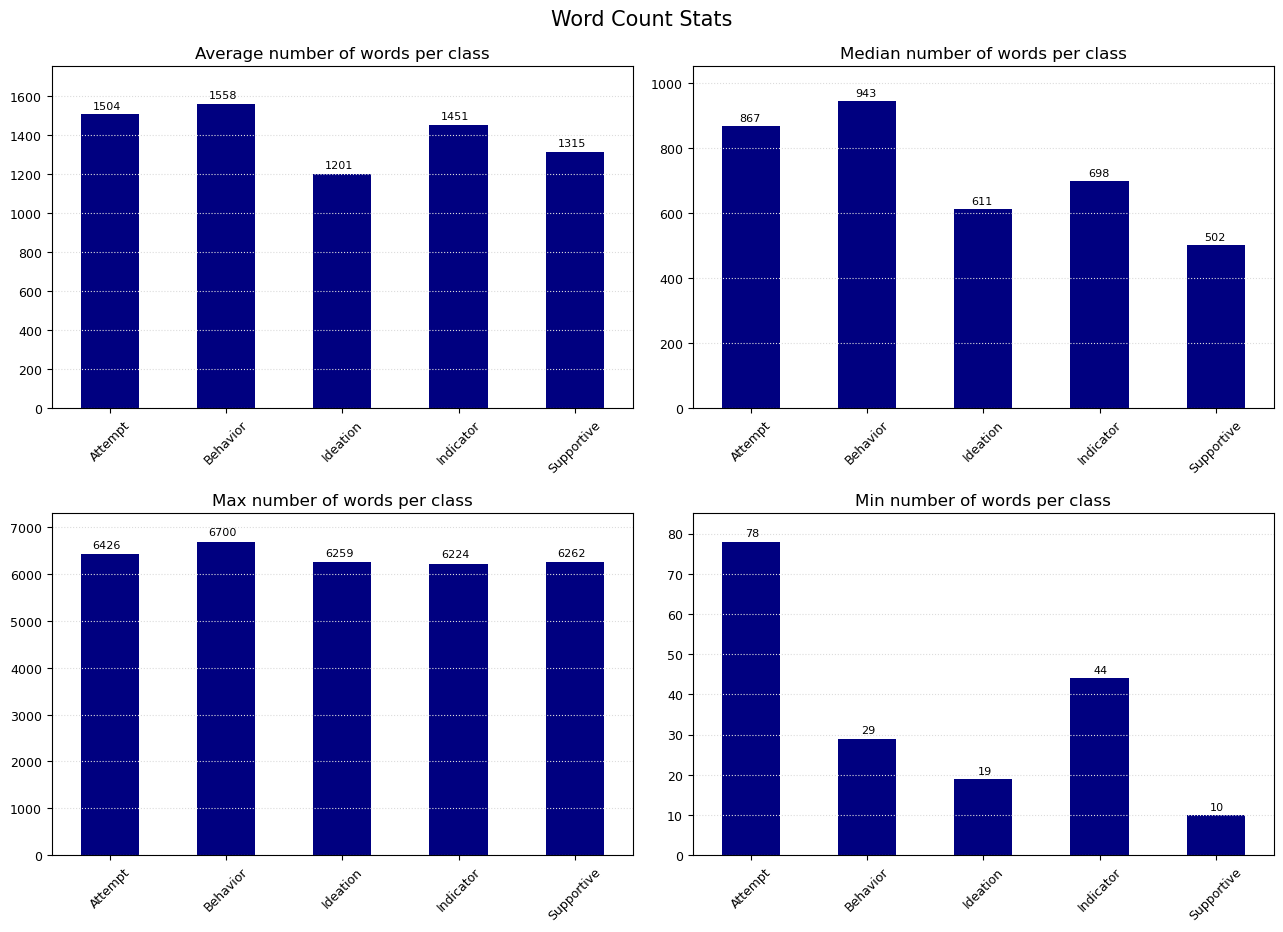

In [37]:
#Plot the stats
fig = plt.figure(figsize=(13,9.5))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

word_ds.plot(x='Label', y='wc_mean', kind='bar', color='navy', rot=45, legend=False, ax=ax1)
ax1.set_title('Average number of words per class', fontsize=12)
ax1.set_xlabel("", fontsize=0.1)
ax1.set_xticklabels(word_ds.Label, fontsize=9)
ax1.set_yticks(range(0,1601,200))
ax1.set_yticklabels(range(0,1601,200), fontsize=9)
ax1.grid(True, axis='y', color='gainsboro', ls= ':', linewidth=0.8)
ax1.set_ylim(0,1750)
for i in ax1.patches:
    ax1.annotate(round(i.get_height(),),
                 xy = (i.get_x()+0.1, i.get_height()+45),
                 ha='left',
                 va='center',
                 fontsize=8)
    
word_ds.plot(x='Label', y='wc_med', kind='bar', color='navy', rot=45, legend=False, ax=ax2)
ax2.set_title('Median number of words per class', fontsize=12)
ax2.set_xlabel("", fontsize=0.1)
ax2.set_xticklabels(word_ds.Label, fontsize=9)
ax2.set_yticks(range(0,1001,200))
ax2.set_yticklabels(range(0,1001,200), fontsize=9)
ax2.grid(True, axis='y', color='gainsboro', ls= ':', linewidth=0.8)
ax2.set_ylim(0,1050)
for i in ax2.patches:
    ax2.annotate(round(i.get_height(),),
                 xy = (i.get_x()+0.15, i.get_height()+25),
                 ha='left',
                 va='center',
                 fontsize=8)
    
word_ds.plot(x='Label', y='wc_max', kind='bar', color='navy', rot=45, legend=False, ax=ax3)
ax3.set_title('Max number of words per class', fontsize=12)
ax3.set_xlabel("", fontsize=0.1)
ax3.set_xticklabels(word_ds.Label, fontsize=9)
ax3.set_yticks(range(0,7001,1000))
ax3.set_yticklabels(range(0,7001,1000), fontsize=9)
ax3.grid(True, axis='y', color='gainsboro', ls= ':', linewidth=0.8)
ax3.set_ylim(0,7300)
for i in ax3.patches:
    ax3.annotate(round(i.get_height(),),
                 xy = (i.get_x()+0.1, i.get_height()+200),
                 ha='left',
                 va='center',
                 fontsize=8)

word_ds.plot(x='Label', y='wc_min', kind='bar', color='navy', rot=45, legend=False, ax=ax4)
ax4.set_title('Min number of words per class', fontsize=12)
ax4.set_xlabel("", fontsize=0.1)
ax4.set_xticklabels(word_ds.Label, fontsize=9)
ax4.set_yticks(range(0,81,10))
ax4.set_yticklabels(range(0,81,10), fontsize=9)
ax4.grid(True, axis='y', color='gainsboro', ls= ':', linewidth=0.8)
ax4.set_ylim(0,85)
for i in ax4.patches:
    ax4.annotate(round(i.get_height(),),
                 xy = (i.get_x()+0.2, i.get_height()+2),
                 ha='left',
                 va='center',
                 fontsize=8)

fig.suptitle('Word Count Stats', fontsize=15)
plt.tight_layout(pad=1.3)
plt.show()

Some considerations:
- The average number of words used by an user is aroud 1,200 - 1,500,depending on the class, whilst the median number of words is much lower: from 500 to 900 words, depending on the class. This means the mean number of words is skewed by few very long posts.
- The longest user's text in all classes is above 6,000 words: these are the texts that skew the mean.

Let's analyze the word count frequecy per class.

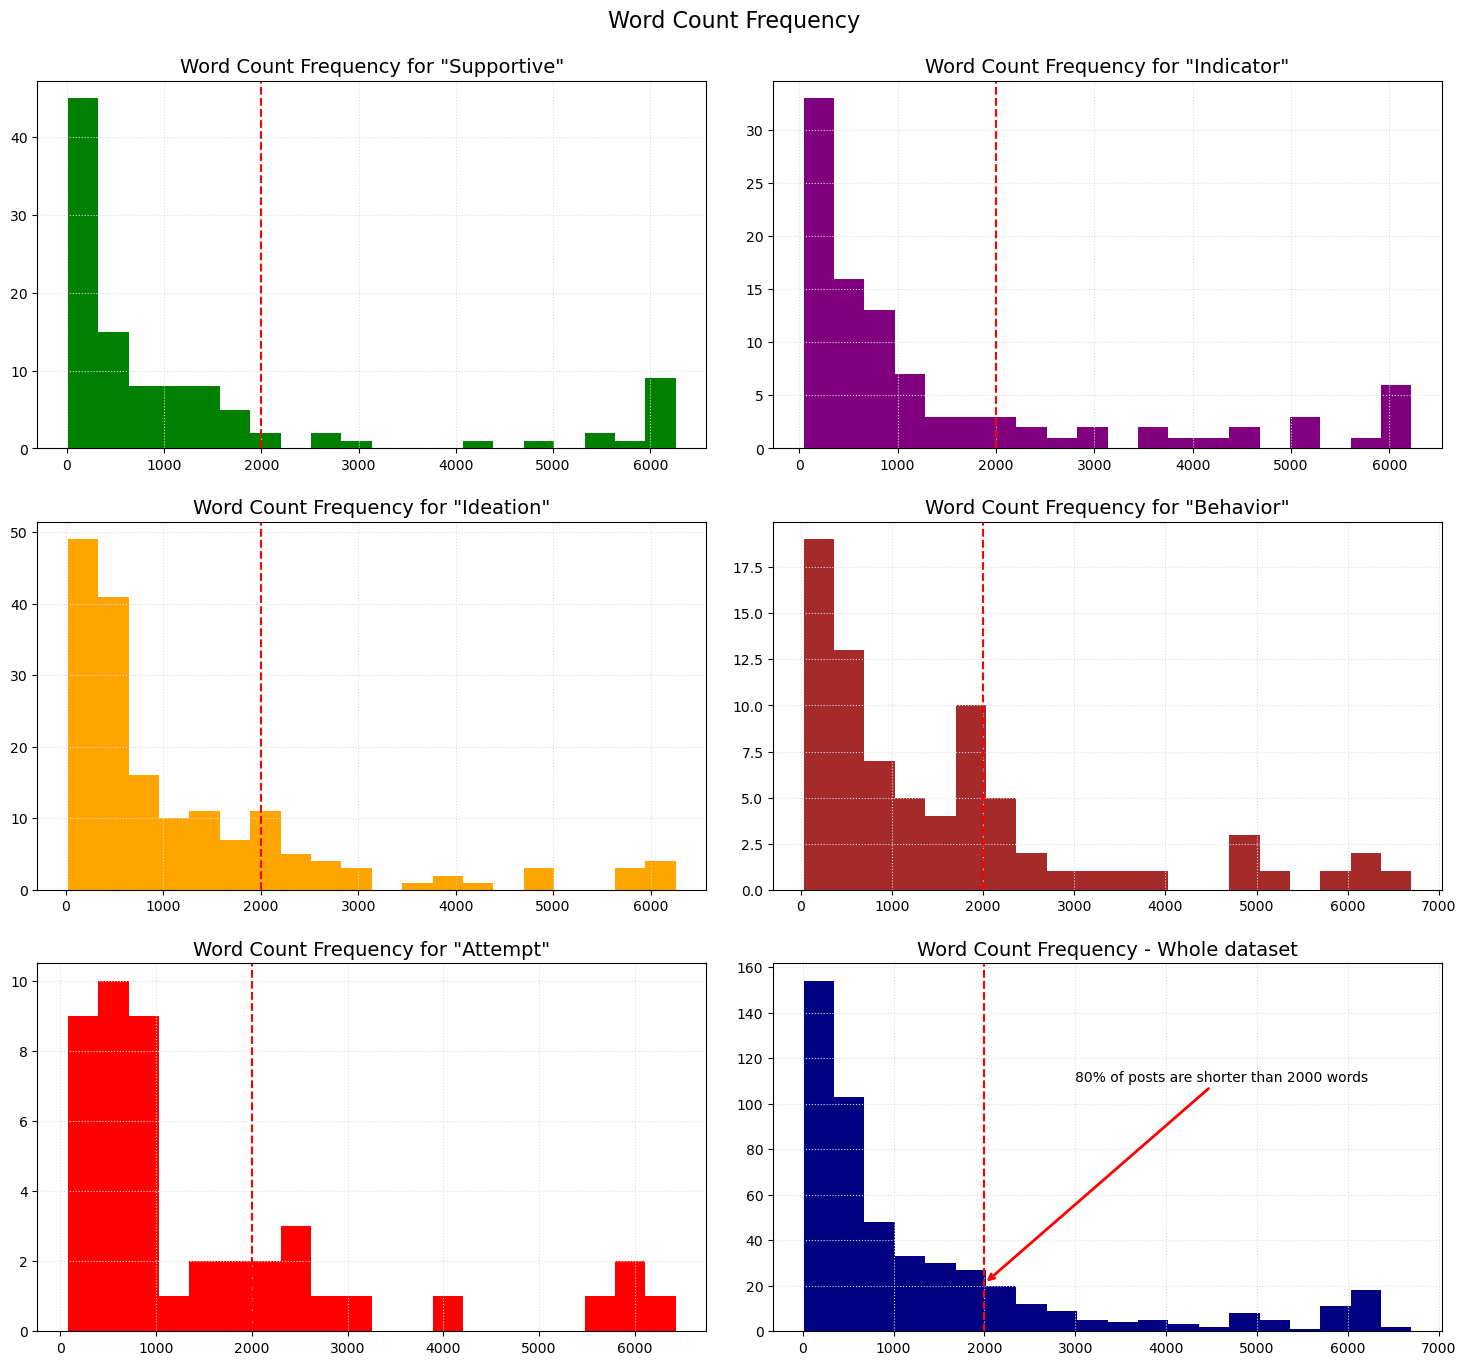

In [38]:
fig = plt.figure(figsize=(15,14))
ax1 = fig.add_subplot(3,2,1)
ax2 = fig.add_subplot(3,2,2)
ax3 = fig.add_subplot(3,2,3)
ax4 = fig.add_subplot(3,2,4)
ax5 = fig.add_subplot(3,2,5)
ax6 = fig.add_subplot(3,2,6)

ax1.hist(data[data['Label'] == 'Supportive']['word_count'], bins=20, color='green')
ax1.axvline(x=2000, color='r', ls='--')
ax1.grid(True, axis='both', color='gainsboro', ls= ':', linewidth=0.8)
ax1.set_title('Word Count Frequency for "Supportive"', fontsize=14)

ax2.hist(data[data['Label'] == 'Indicator']['word_count'], bins=20, color='purple')
ax2.axvline(x=2000, color='r', ls='--')
ax2.grid(True, axis='both', color='gainsboro', ls= ':', linewidth=0.8)
ax2.set_title('Word Count Frequency for "Indicator"', fontsize=14)

ax3.hist(data[data['Label'] == 'Ideation']['word_count'], bins=20, color='orange')
ax3.axvline(x=2000, color='r', ls='--')
ax3.grid(True, axis='both', color='gainsboro', ls= ':', linewidth=0.8)
ax3.set_title('Word Count Frequency for "Ideation"', fontsize=14)

ax4.hist(data[data['Label'] == 'Behavior']['word_count'], bins=20, color='brown')
ax4.axvline(x=2000, color='r', ls='--')
ax4.grid(True, axis='both', color='gainsboro', ls= ':', linewidth=0.8)
ax4.set_title('Word Count Frequency for "Behavior"', fontsize=14)

ax5.hist(data[data['Label'] == 'Attempt']['word_count'], bins=20, color='red')
ax5.axvline(x=2000, color='r', ls='--')
ax5.grid(True, axis='both', color='gainsboro', ls= ':', linewidth=0.8)
ax5.set_title('Word Count Frequency for "Attempt"', fontsize=14)

ax6.hist(data['word_count'], bins=20, color='navy')
ax6.axvline(x=2000, color='r', ls='--')
ax6.grid(True, axis='both', color='gainsboro', ls= ':', linewidth=0.8)
ax6.set_title('Word Count Frequency - Whole dataset', fontsize=14)
ax6.annotate('80% of posts are shorter than 2000 words', xy=(2000,21), xytext=(3000,110), fontsize=10,
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color='r', lw=2))

fig.suptitle('Word Count Frequency', fontsize=16)
plt.tight_layout(pad=1.9)
plt.show()

In [39]:
print("Percentage of users' texts shorter than 2,000 words: {}%.".\
      format(round(len(data[data['word_count'] <= 2000].index)/data.shape[0]*100,)))

Percentage of users' texts shorter than 2,000 words: 79%.


It does seem that Word Count Frequency is more or less the same in all classes (with users labelled as "Attempt" and "Behavior" that tend to write slightly longer texts then the others).  
**Almost 80% of the users' posts are shorther than 2,000 words**.

#### Wordcloud Analysis

In [40]:
# To better understand the semantics of the sentences, I'll remove the stopwords from 2 different stopword lists
#NLTK Stopword List
stops = set(stopwords.words('english'))
# wordcloud stopword list
sw = STOPWORDS.copy()

sw = sw.union(stops)

#However, I modify the default lists of stopwords to exclude words that could be relevant for this analysis
sw = sw - set(["can't",'cannot', 'down', "mustn't", 'myself', 'no', 'ourselves', 'over', 'own', 'yourself'])
print('Length of stop word list:', len(sw))

Length of stop word list: 217


We know that 80% of users' posts are shorter than 2,000 words, so I'll plot word clouds per each of the class, up to the most frequent 2,000 words.

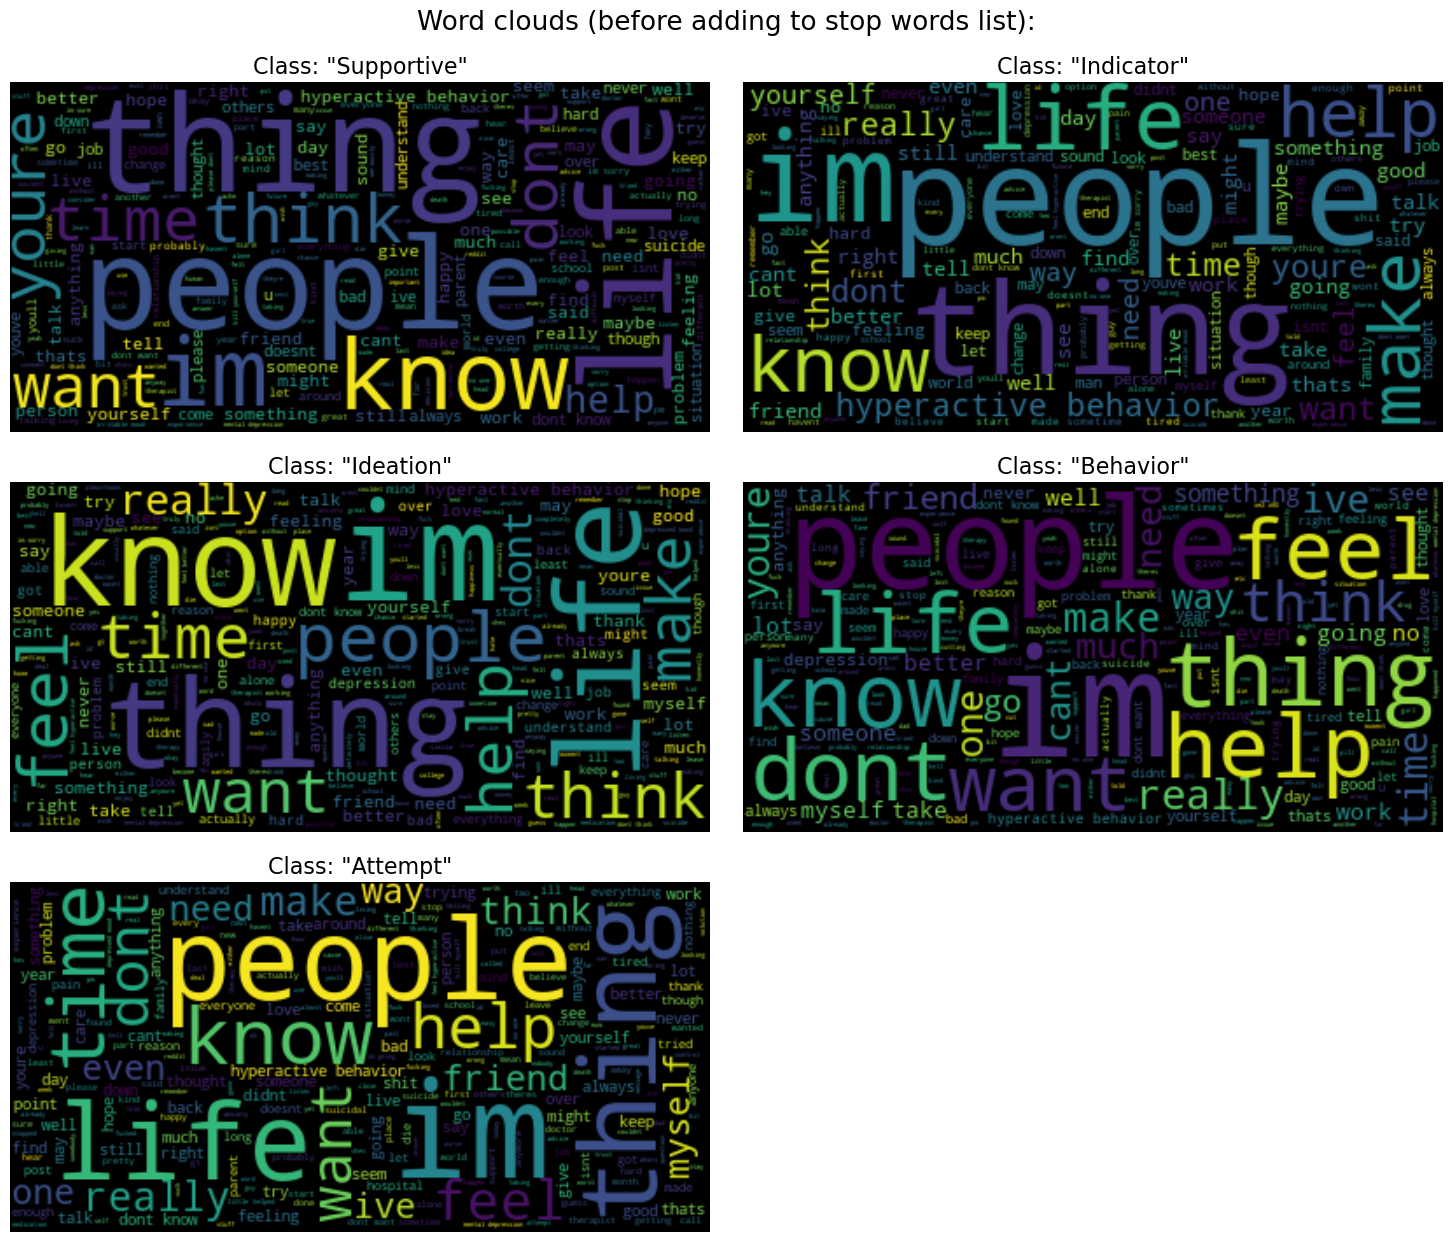

In [41]:
class_list = ['Supportive', 'Indicator', 'Ideation', 'Behavior', 'Attempt']
i=0
wc = WordCloud(background_color = 'black', max_words = 2000, stopwords = sw, random_state=96)

fig = plt.figure(figsize=(15,21))
for l in class_list:
    i+=1
    post = data[data['Label'] == l]['Post']
    txt = ' '.join(post)
    wc.generate(txt)   
    plt.subplot(5, 2, i)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title('Class: "{}"'.format(l), fontsize=16)

plt.suptitle('Word clouds (before adding to stop words list):', fontsize=19)
plt.tight_layout(pad=2.4)
plt.show()

Word clouds don't really show any type of patterns, or semantic meaning, with regard to the classes: the most commnon words (life, people, thing, know, want...) are in fact shared by all classes.  
I'll add these "shared" words to the list of stop words, trying to show a clearer pattern, or boundary, that will help us clarify the meaning of the classes themselves.

In [42]:
# Add to the stopword list non-meaningful words or words shared by all classes
sw.update(['im', 'know', 'will', 'dont', 'really', "ive", 'youre', 'life', 'friend', 'live', 'give', 'love', 'things', 'way',
           'going', 'thats', 'people', 'time', 'even', 'feel', 'make', 'one', 'better', 'cant', 'think', 'need', 'no', 'help',
           'want', 'myself','hyperactive', 'behavior', 'now', 'talk', 'go', 'much', 'something', 'right', 'say', 'yourself',
           'good', 'find', 'see', 'someone', 'may', 'still', 'tell', 'back', 'well', 'lot', 'long', 'person', 'year', 'day',
           'work', 'take', "didn't", 'seem', 'anything', 'might', 'around', 'thought', 'never', 'always', "didnt", 'maybe',
           'over', 'doesnt', 'point', 'though', 'made', 'keep', 'everything', 'come', 'care', 'please', 'sure', 'thank',
           'anyone', 'getting', 'post', 'everyone', 'nothing', 'feeling', 'friends', 'years', 'look', 'pretty', 'isnt', 'put',
           'sound', 'got', 'seems', 'away', 'first', 'every', 'try', 'thing', 'let', 'youll', 'youve', 'said', 'u', 'theres',
           'us', 'sounds', 'trying', 'understand', 'happy', 'hard', 'bad', 'best', 'many', 'school', 'family', 'mood', 'world',
           'job', 'mind', 'actually', 'change', 'own', 'new', 'little', 'makes', 'believe', 'start', 'able', 'mental', 'ill',
           'end', 'enough', 'id', 'sometimes', 'probably', 'wont', 'down', 'parents', 'reason', 'least', 'bit', 'man', 'kind',
           'another', 'stop', 'times', 'place', 'without', 'done', 'last', 'problems', 'different', 'part', 'havent', 'problem',
           'hear', 'days', 'two'])

Re-plot the wordclouds:

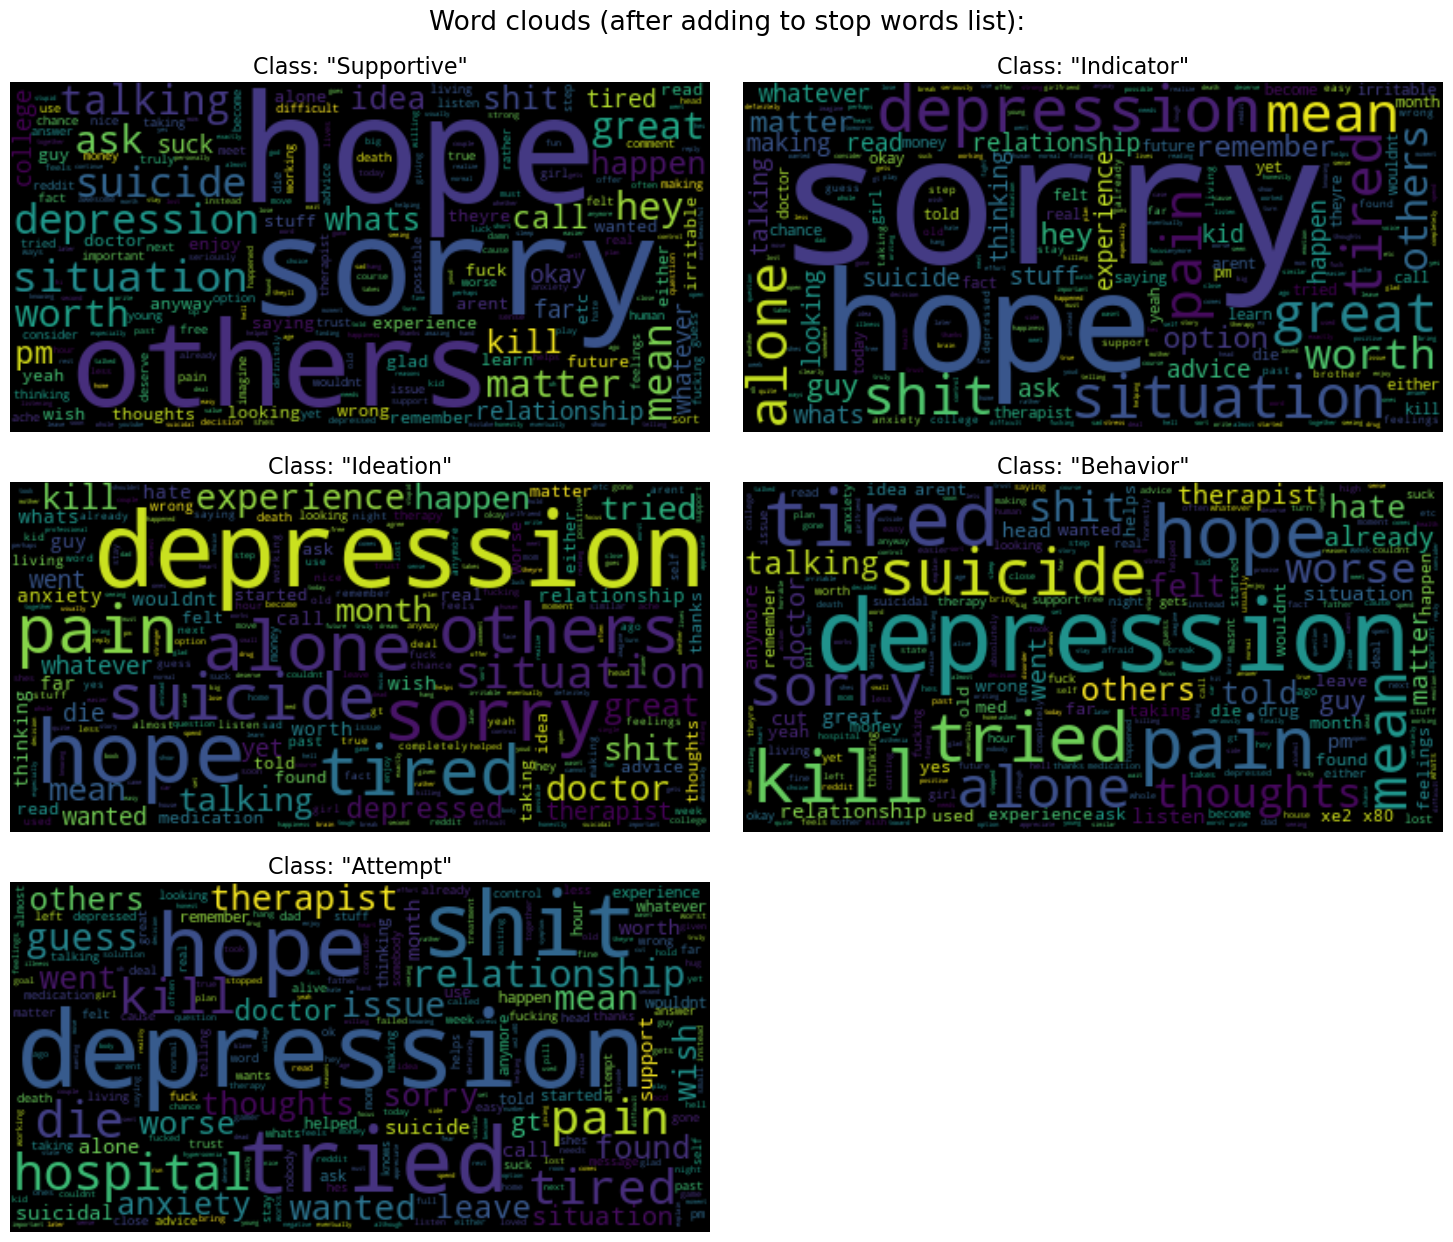

In [43]:
class_list = ['Supportive', 'Indicator', 'Ideation', 'Behavior', 'Attempt']
i=0
wc = WordCloud(background_color = 'black', max_words = 2000, stopwords = sw, random_state=96)

fig = plt.figure(figsize=(15,21))
for l in class_list:
    i+=1
    post = data[data['Label'] == l]['Post']
    txt = ' '.join(post)
    wc.generate(txt)   
    plt.subplot(5, 2, i)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title('Class: "{}"'.format(l), fontsize=16)
    
plt.suptitle('Word clouds (after adding to stop words list):', fontsize=19)
plt.tight_layout(pad=2.4)
plt.show()

In [44]:
print('Length of stop word list used to build the Word Clouds:', len(sw))

Length of stop word list used to build the Word Clouds: 372


We can have now a better understanding of the classes, and start defining the boundary between users "at risk" and "not at risk":
- Words like "hope" and "sorry", although used in each class, have a greater relative frequency in the texts posted by the users labelled as "Supportive" and "Indicator".
- The word "depression", although widely used in all labels, is very frequent in the texts posted by the users labelled as "Ideation", "Behavior", and "Attempt", alongside with words such as "alone", "pain", "kill", "suicide", "hospital", "tired"...

Let's analyze now the relative frequency of the 20 most used words in each class.

#### Top 20 words - Relative Frequency Analysis

In [45]:
#let's remove the stop words
data['Post_nostopwords'] = data['Post'].apply(lambda x: ' '.join([word for word in x.split() if word not in (sw)]))

#Create a dataframe with the top 20 most used words (excluding stop words) and their frequency 
top_words = (' '.join(data.Post_nostopwords)).split()
tw = {'word':[], 'frequency':[]}
for tup in collections.Counter(top_words).most_common(20):
    tw['word'].append(tup[0])
    tw['frequency'].append(tup[1])
top_words = pd.DataFrame(tw)

#Plot the df
top_words

word  frequency
0   depression       1001
1         hope        810
2        sorry        672
3      suicide        666
4         pain        600
5        tired        541
6       others        511
7        alone        481
8     thoughts        461
9    situation        460
10        shit        453
11       great        425
12        kill        424
13     talking        424
14       worth        421
15       tried        418
16         ask        353
17       whats        353
18         hey        340
19      wanted        337

In [46]:
#Create lists with the words used in each class
supportive_words = (' '.join(data[data['Label'] == 'Supportive'].Post_nostopwords)).split()
indicator_words = (' '.join(data[data['Label'] == 'Indicator'].Post_nostopwords)).split()
ideation_words = (' '.join(data[data['Label'] == 'Ideation'].Post_nostopwords)).split()
behavior_words = (' '.join(data[data['Label'] == 'Behavior'].Post_nostopwords)).split()
attempt_words = (' '.join(data[data['Label'] == 'Attempt'].Post_nostopwords)).split()

#Add columns per each class, counting the word frequency
top_words['Supportive'] = top_words['word'].apply(lambda x: supportive_words.count(x))
top_words['Indicator'] = top_words['word'].apply(lambda x: indicator_words.count(x))
top_words['Ideation'] = top_words['word'].apply(lambda x: ideation_words.count(x))
top_words['Behavior'] = top_words['word'].apply(lambda x: behavior_words.count(x))
top_words['Attempt'] = top_words['word'].apply(lambda x: attempt_words.count(x))

#Calculate the frequency in % of each word in each class (calculated on the total per class)
top_words['Supportive'] = top_words['Supportive'].apply(lambda x: round(x/top_words['Supportive'].sum()*100,1))
top_words['Indicator'] = top_words['Indicator'].apply(lambda x: round(x/top_words['Indicator'].sum()*100,1))
top_words['Ideation'] = top_words['Ideation'].apply(lambda x: round(x/top_words['Ideation'].sum()*100,1))
top_words['Behavior'] = top_words['Behavior'].apply(lambda x: round(x/top_words['Behavior'].sum()*100,1))
top_words['Attempt'] = top_words['Attempt'].apply(lambda x: round(x/top_words['Attempt'].sum()*100,1))

#Let's plot the dataframe to check the result
top_words

word  frequency  Supportive  Indicator  Ideation  Behavior  Attempt
0   depression       1001         5.9        7.6      12.1      13.0     10.0
1         hope        810         9.4        8.4       8.2       6.2      6.7
2        sorry        672         8.1        8.6       6.0       4.9      4.3
3      suicide        666         7.2        5.3       6.4       7.0      7.2
4         pain        600         4.2        6.4       5.9       7.4      5.8
5        tired        541         3.8        5.4       5.2       7.2      5.6
6       others        511         6.7        4.5       5.1       4.0      4.3
7        alone        481         3.4        5.0       5.8       4.8      3.7
8     thoughts        461         4.0        3.1       4.8       5.6      5.8
9    situation        460         5.6        5.4       4.3       3.2      3.8
10        shit        453         3.8        5.5       3.7       4.0      7.0
11       great        425         4.6        5.6       3.8       3.4      3.0
12        kill        424         4.0        3.2       3.5       5.7      5.6
13     talking        424         5.4        3.5       4.2       4.1      3.0
14       worth        421         5.0        5.0       3.8       3.0      3.9
15       tried        418         2.6        3.0       4.1       5.5      7.2
16         ask        353         4.5        3.6       3.0       3.0      3.4
17       whats        353         4.2        4.2       3.4       2.3      2.8
18         hey        340         4.7        4.3       3.0       1.9      2.3
19      wanted        337         2.9        2.4       3.7       3.6      4.5

In [47]:
#Add a new column with the sum (along the columns) of each word % frequency: "sum_freq"
top_words['sum_freq'] = top_words[top_words.columns[2:]].sum(axis=1)

#Drop the "frequency" column
top_words.drop(['frequency'], axis=1, inplace=True)

#Calculate the relative frequecy of each word (relative to the frequency of each word in each class)  
top_words['Supportive'] = top_words[['Supportive', 'sum_freq']].apply(lambda x: round(x[0]/x[1]*100,2), axis=1)
top_words['Indicator'] = top_words[['Indicator', 'sum_freq']].apply(lambda x: round(x[0]/x[1]*100,2), axis=1)
top_words['Ideation'] = top_words[['Ideation', 'sum_freq']].apply(lambda x: round(x[0]/x[1]*100,2), axis=1)
top_words['Behavior'] = top_words[['Behavior', 'sum_freq']].apply(lambda x: round(x[0]/x[1]*100,2), axis=1)
top_words['Attempt'] = top_words[['Attempt', 'sum_freq']].apply(lambda x: round(x[0]/x[1]*100,2), axis=1)

#Drop the "sum_freq" column
top_words.drop(['sum_freq'], axis=1, inplace=True)

#Let's plot the dataframe to see the results
top_words

word  Supportive  Indicator  Ideation  Behavior  Attempt
0   depression       12.14      15.64     24.90     26.75    20.58
1         hope       24.16      21.59     21.08     15.94    17.22
2        sorry       25.39      26.96     18.81     15.36    13.48
3      suicide       21.75      16.01     19.34     21.15    21.75
4         pain       14.14      21.55     19.87     24.92    19.53
5        tired       13.97      19.85     19.12     26.47    20.59
6       others       27.24      18.29     20.73     16.26    17.48
7        alone       14.98      22.03     25.55     21.15    16.30
8     thoughts       17.17      13.30     20.60     24.03    24.89
9    situation       25.11      24.22     19.28     14.35    17.04
10        shit       15.83      22.92     15.42     16.67    29.17
11       great       22.55      27.45     18.63     16.67    14.71
12        kill       18.18      14.55     15.91     25.91    25.45
13     talking       26.73      17.33     20.79     20.30    14.85
14       worth       24.15      24.15     18.36     14.49    18.84
15       tried       11.61      13.39     18.30     24.55    32.14
16         ask       25.71      20.57     17.14     17.14    19.43
17       whats       24.85      24.85     20.12     13.61    16.57
18         hey       29.01      26.54     18.52     11.73    14.20
19      wanted       16.96      14.04     21.64     21.05    26.32

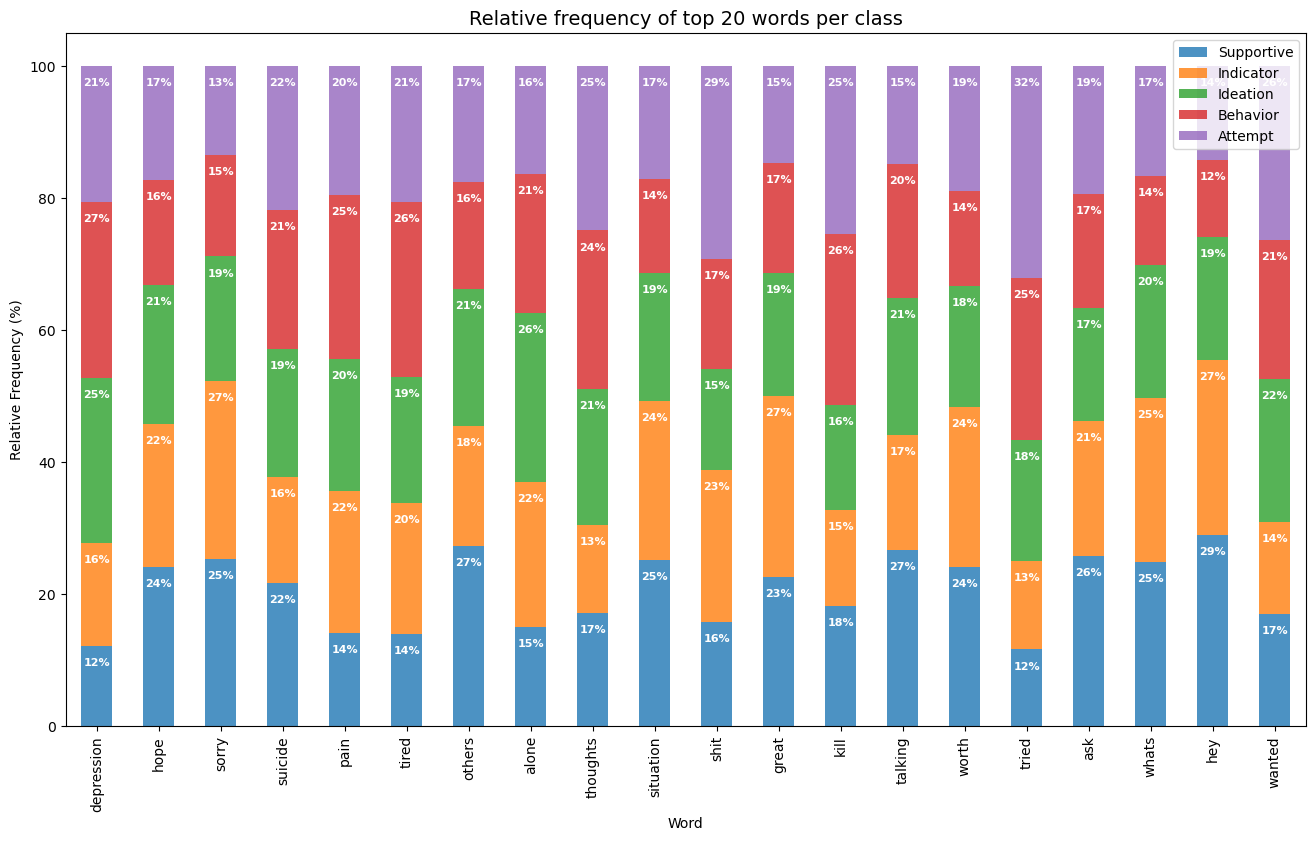

In [48]:
barchart = top_words.plot(x='word', y=top_words.columns[1:], kind='bar', legend=True, stacked=True, alpha=0.8, figsize=(16,9))
for bar in barchart.patches:
    barchart.text(bar.get_x() + bar.get_width() / 2,
                  bar.get_height() + bar.get_y()-3,
                  str(round(bar.get_height(),))+'%',
                  ha='center',
                  color='w',
                  weight='bold',
                  size=8)
plt.title('Relative frequency of top 20 words per class', fontsize=14)
plt.xlabel('Word', fontsize=10)
plt.ylabel('Relative Frequency (%)', fontsize=10)
plt.legend(loc='best', fontsize='10', )
plt.show()

Relative Frequency Analysis results:
- Users labelled as **Supportive** and **Indicator** use, more often then the others, words such as "sorry", and "worth"; this suggests that post authors may express sympathy for someone else's problem or life situation.
- The same users also use (more often than the others) non-meangiful words such as "great", "whats", and "hey". Although these words don't carry any meaning per se (or anyway not outside the context), this difference may indicate a tendency of these users to use "lighter" words, and an overall tone of voice more friendly, easy-going, and casual. 
- Users labelled as **Ideation**, **Behavior**, and **Attempt** use, more often then the others, words such as "depression", "thoughts", "tried", and "wanted". This suggests an ongoing struggle with mental issues like depression, a failed attempt at something (maybe suicide, or maybe a life goal), and a general feeling of regret.

---

E.D.A. Results:
- **Supportive** and **Indicator**: these users don't seem to suffer from mental issues (or anyway not in a sever way) and they are not at risk of attempting suicide or self-harm. **I'll classify these users as Not-at-risk (Negative Class)**.
- **Ideation**, **Behavior**, **Attempt**: these users struggle with depression, or other mental issues, they may be having suicidal thoughts, dealing with suicidal behavior, have already tried to commit suicide, or actively planning to do it. **These are the users at-risk** of attempting suicide or self-harm **(Positive Class)**.

---

I'll create a new column, called **class**, with following values:
- **0**. For users belonging to the labels **Supportive** and **Indicator** (Negative Class). 
- **1**. For users belonging to the labels **Ideation**, **Behavior**, and **Attempt** (Positive Class).

In [49]:
data['class'] = data['Label'].apply(lambda x: 0 if x in ['Supportive', 'Indicator'] else 1)

Let's plot the distribution and breakdown of the new classes

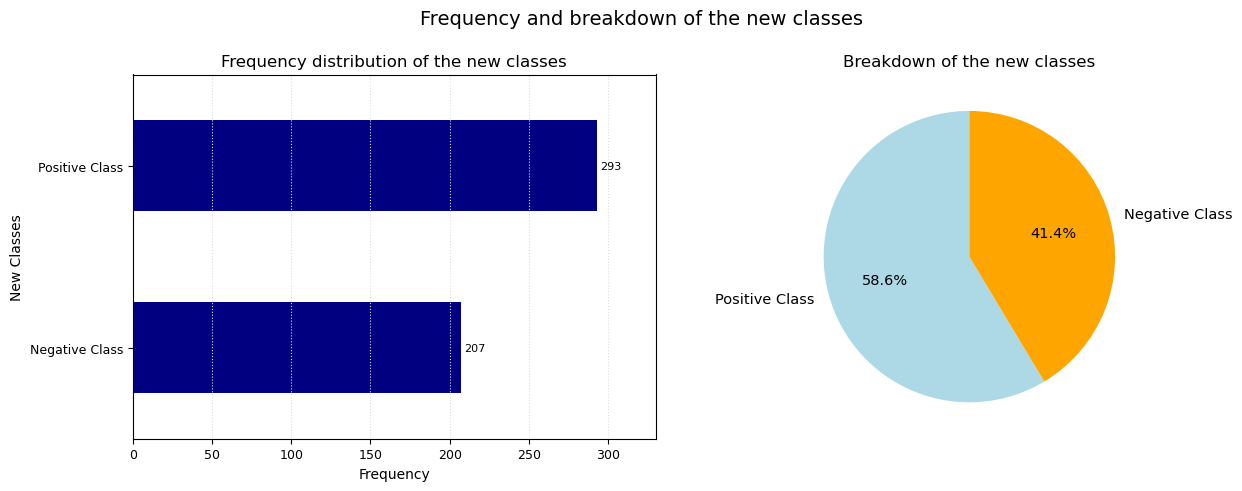

In [50]:
class_freq = data.groupby(['class']).size()

fig = plt.figure(figsize=(13,5))
barchart = fig.add_subplot(1,2,1) 
piechart = fig.add_subplot(1,2,2)

class_freq.plot(x=class_freq.index, y=class_freq, kind='barh', color='navy', ax=barchart)
for i in barchart.patches:
    barchart.annotate(i.get_width(), # get the frequency of the variable categories
                      xy = (i.get_width()+2, i.get_y() + i.get_height()-0.25), # set the coordinates for each label
                      ha='left', # set the horizontal alignment
                      va='center', # set the vertical alignment
                      fontsize=8) # set the font size

barchart.set_title('Frequency distribution of the new classes', fontsize=12)
barchart.set_xlabel("Frequency", fontsize=10)
barchart.set_ylabel('New Classes', fontsize=10)
barchart.set_xlim(0, 330)
barchart.set_xticks(range(0,331,50)) 
barchart.set_xticklabels(range(0,331,50), fontsize=9)
barchart.set_yticklabels(['Negative Class', 'Positive Class'], fontsize=9)
barchart.grid(True, axis='x', color='gainsboro', ls= ':', linewidth=0.8)

data['class'].value_counts().plot(kind='pie',
                                  #figsize=(3,3), # set axis lengths
                                  autopct='%1.1f%%',
                                  startangle=90, # rotates the start of the pie by ... degree counter-clock wise
                                  shadow=False, #add a shadow
                                  labels=['Positive Class', 'Negative Class'],
                                  pctdistance=0.6, # push out the slice values
                                  colors=['lightblue','orange'],
                                  fontsize=10.5,
                                  #explode=[0.01,0.01,0.01,0.01,0.01],
                                  ax=piechart)

piechart.set_title('Breakdown of the new classes', fontsize=12)
piechart.set_ylabel('')

fig.suptitle('Frequency and breakdown of the new classes', fontsize=14)
plt.tight_layout(pad=1.3)
plt.show()

The dataset is quite imbalanced: almost 60% of the users belong to the positive class, that is users at risk of attempting suicide or self-harm.

Let's plot now the word clouds of the new classes (up to the most frequent 2,000 words).

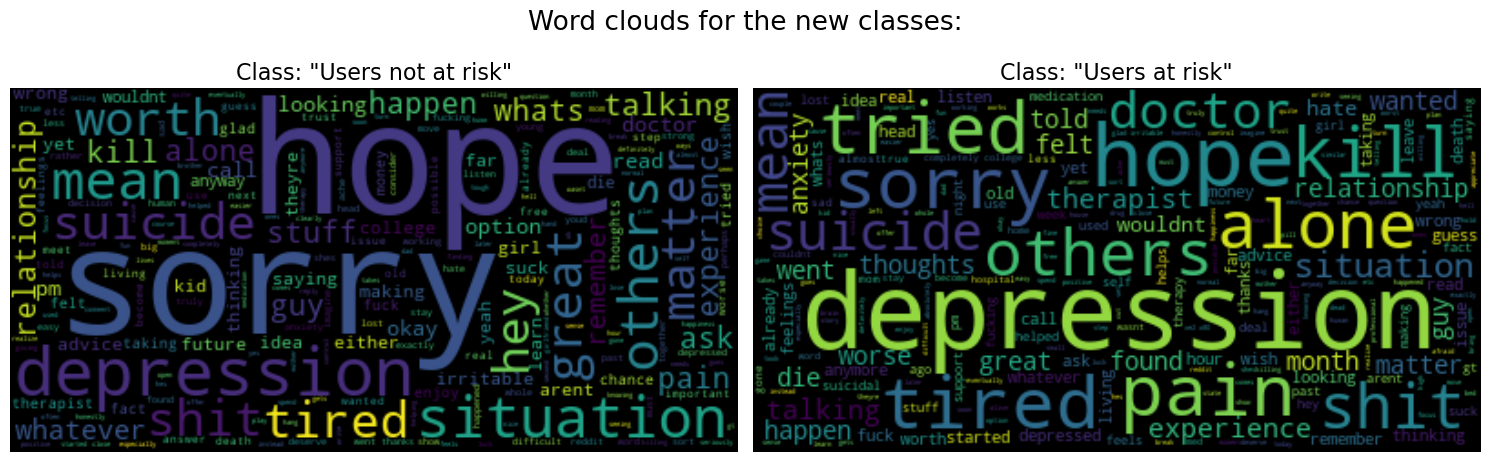

In [51]:
class_list = {0: 'Users not at risk', 1: 'Users at risk'}
i=0
wc = WordCloud(background_color = 'black', max_words = 2000, stopwords = sw, random_state=96)

fig = plt.figure(figsize=(15,5))
for l in class_list:
    i+=1
    post = data[data['class'] == l]['Post']
    txt = ' '.join(post)
    wc.generate(txt)   
    plt.subplot(1, 2, i)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title('Class: "{}"'.format(class_list[l]), fontsize=16)
    
plt.suptitle('Word clouds for the new classes:', fontsize=19)
plt.tight_layout()
plt.show()

We can see now a clear distinction between the classes.

Let's plot now the relative frequency of the top 20 words.

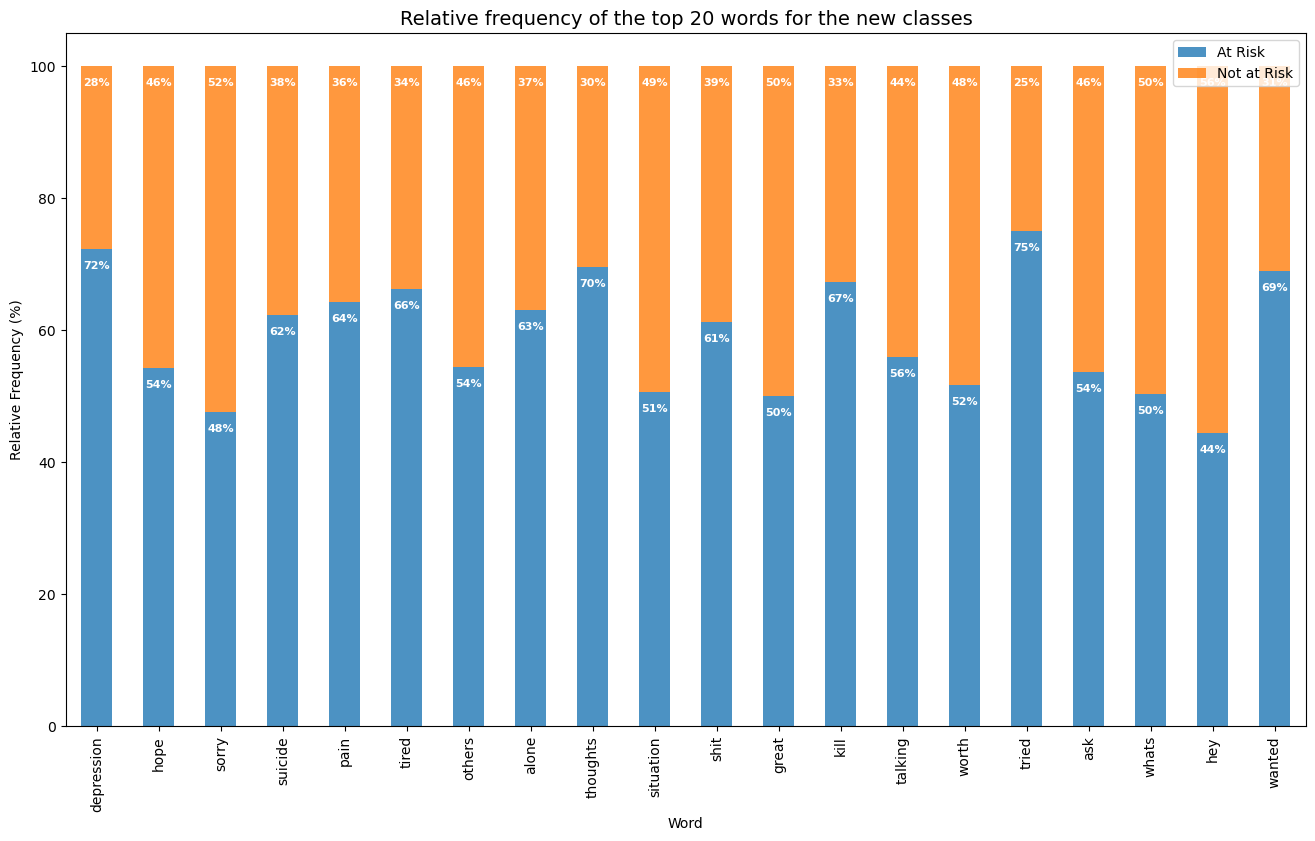

In [52]:
top_words['At Risk'] = top_words[['Ideation', 'Behavior', 'Attempt']].apply(lambda x: x[0]+x[1]+x[2], axis=1)
top_words['Not at Risk'] = top_words[['Supportive', 'Indicator']].apply(lambda x: x[0]+x[1], axis=1)

barchart = top_words.plot(x='word', y=top_words.columns[6:], kind='bar', legend=True, stacked=True, alpha=0.8, figsize=(16,9))
for bar in barchart.patches:
    barchart.text(bar.get_x() + bar.get_width() / 2,
                  bar.get_height() + bar.get_y()-3,
                  str(round(bar.get_height(),))+'%',
                  ha='center',
                  color='w',
                  weight='bold',
                  size=8)
plt.title('Relative frequency of the top 20 words for the new classes', fontsize=14)
plt.xlabel('Word', fontsize=10)
plt.ylabel('Relative Frequency (%)', fontsize=10)
plt.legend(loc='best', fontsize='10', )
plt.show()

Again, we can see now a clearer boundary between the classses, whereas users "At Risk" use, much more than users "Not at Risk", words such as: depression, tried, thoughts, wanted, tired, pain, suicide, kill, alone, shit. 

## 4. Data Preparation <a name=preparation></a>

Steps to process and prepare the data for modeling:
1. Drop not-relevant features.
2. Remove stopwords from data.
3. Split dataset into training and testing sets.
4. Tokenize the posts.
5. Pad the sequences.

In [53]:
#Import needed libraries
import keras
import random
from random import randrange, seed
from keras.preprocessing.text import Tokenizer
import numpy as np
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split

### 4.1. Drop non-relevant features <a name=features></a>

In [54]:
#create a copy of the dataset before starting the data preparation
processed_data = data.copy()

#Drop not relevant features
processed_data.drop(['User', 'word_count', 'Label', 'Post_nostopwords'], axis=1, inplace=True)
processed_data.tail()

Post  class
495  its not the end it just feels that way or at l...      0
496  it was a skype call but she ended it and ventr...      0
497  that sounds really weird maybe you were distra...      0
498  dont know there as dumb as it sounds i feel hy...      1
499  gt it gets better trust me ive spent long enou...      1

### 4.2. Remove the stop words <a name=stopwords></a>

In [55]:
#let's visualize a random post
random.seed(3)
processed_data.loc[randrange(500)]['Post']

'no more ideas i dont agree with live for others kind of advice i think you should live for yourself and your friends and family the world isnt going to be fixed any time soon so stop thinking its all on your shoulders regular exercise and a lack of excessive stress is important to a good life so is a decent job work is now stressful yes its never done im on a long break now its tired hot and humid where i now live so i cant really do anything i cant handle the heat well i want to prepare for my death before i go back to work its not only that the career enabled me to live a certain lifestyle and live in a certain place and not have to worry too much about money and other things why would you like that i dont think there are any other kinds of job i could do in this country it has been 5 years since i lost my job i have tried my best the things i lost in my life i believe them to be extremely fundamental and important things i also lost a life that had little worry and stress now i hav

In [56]:
random.seed(3)
print('Length of the post before removing the stop words:', len(processed_data.loc[randrange(500)]['Post']))

Length of the post before removing the stop words: 2269


In [57]:
#let's remove the stop words
processed_data['Post']=processed_data['Post'].apply(lambda x: ' '.join([word for word in x.split() if word not in (STOPWORDS)]))

In [58]:
random.seed(3)
processed_data.loc[randrange(500)]['Post']

'ideas dont agree live others kind advice think live friends family world isnt going fixed time soon stop thinking shoulders regular exercise lack excessive stress important good life decent job work now stressful yes never done im long break now tired hot humid now live cant really anything cant handle heat well want prepare death go back work career enabled live certain lifestyle live certain place worry much money things dont think kinds job country 5 years lost job tried best things lost life believe extremely fundamental important things lost life little worry stress now job gets worse every day doesnt allow time exercise boiling hot city saps energy horrible bitchy colleagues norm come realize really liked living country kind still jobs will worse live world shitty jobs one best jobs world threw away cant tolerate job isnt good say rest move different job industry city time less hot humid place wont good climate city even ill still lost years life people dont understand suicide a

In [59]:
random.seed(3)
print('Length of the post after removing the stop words:', len(processed_data.loc[randrange(500)]['Post']))

Length of the post after removing the stop words: 1369


### 4.3. Split the dataset into training and testing sets <a name=split></a>

Let's split the dataset into train and test sets. I use 20% of the dataset (100 observations) as test data, and the stratify parameter to preserve the class imbalance.

In [60]:
x_train, x_test, y_train, y_test = train_test_split(processed_data['Post'], processed_data['class'], test_size=0.2,
                                                    random_state=666, stratify = processed_data['class'])

In [61]:
print('Number of observation in the training dataset:', x_train.shape[0])
print('Number of observation in the testing dataset:', x_test.shape[0])

Number of observation in the training dataset: 400
Number of observation in the testing dataset: 100


### 4.4. Tokenize the text <a name=tokenize></a>

I am going to tokenize the posts, that is I'll turn each user's text into a list of individual words and then convert the words into integers, using the Keras Tokenizer class.  
Keras Tokenizer creates the vocabulary index based on word frequency, and then it takes each word in the text and replaces it with its corresponding integer value from the created word index.  
To avoid data leaking, I train the Keras Tokenizer on the training data only, and I'll use the trained Tokenizer to convert the words into integers for both the training and testing sets. Since there may be words in the testing set that don't appear in the training data, so the Tokenizer won't know how to convert these words, I use a token (OOV) to define those out-of-vocabulary words (Keras Tokenzer will give to the OOV token an index of 1).

In [62]:
#let's create a tokenizer object with a token for out-of-vocabulary words
tokenizer = Tokenizer(oov_token='OOV')

In [63]:
#let's fit the tokenizer on the training set only
tokenizer.fit_on_texts(x_train)

In [64]:
#let's visualize a random post from the training set
random.seed(13)
x_train.reset_index(inplace=False, drop=True)[randrange(400)]

'dont much currently lifeguard bit cash im heading school september pretty much whether something want idea currently never feel anything used make happy years happy minutes guess making things programming art stuff havent able concentrate much anything will plan something lose drive dont follow though building really closest pool 15 25 minute drive guess try going every swam much long didnt much appeal last two seasons competed last years estimated swimming somewhere around 3 million yards year dont really feel going back actually lab animals dont make feel better better shape people used swim 2 4 hours day five days week dont anymore im still physically healthy blood test nothing showed take multivitamin eat fairly well honestly dont know guess something wrong brain functions im really stressed never bee one worry much lately ive wishing way though medication death whatever medicines never worked well anti depressants ive taken done fuck guess friends finding will everyday hard let a

In [65]:
#convert text into lists of integers for the training set
x_train = tokenizer.texts_to_sequences(x_train)

In [66]:
#let's visualize the same post after tokenizing
random.seed(13)
x_train[randrange(400)]

[3,
 27,
 671,
 10748,
 143,
 3200,
 2,
 3495,
 81,
 4670,
 145,
 27,
 391,
 26,
 9,
 245,
 671,
 49,
 8,
 48,
 237,
 25,
 80,
 64,
 80,
 682,
 211,
 206,
 13,
 1967,
 720,
 200,
 156,
 114,
 2404,
 27,
 48,
 6,
 460,
 26,
 372,
 630,
 3,
 730,
 71,
 1272,
 12,
 1737,
 3733,
 763,
 1153,
 1410,
 630,
 211,
 34,
 22,
 98,
 6183,
 27,
 79,
 72,
 27,
 2343,
 160,
 173,
 5691,
 10749,
 160,
 64,
 10750,
 2845,
 453,
 92,
 324,
 1754,
 10751,
 123,
 3,
 12,
 8,
 22,
 58,
 116,
 10752,
 1877,
 3,
 25,
 8,
 19,
 19,
 1337,
 5,
 237,
 2485,
 261,
 481,
 411,
 55,
 961,
 155,
 480,
 3,
 229,
 2,
 41,
 843,
 653,
 1231,
 1158,
 89,
 1495,
 43,
 10753,
 768,
 1273,
 39,
 293,
 3,
 4,
 211,
 26,
 180,
 417,
 7239,
 2,
 12,
 5176,
 49,
 10754,
 16,
 656,
 27,
 943,
 29,
 2254,
 23,
 71,
 346,
 217,
 169,
 3584,
 49,
 471,
 39,
 910,
 1657,
 29,
 642,
 164,
 223,
 211,
 45,
 368,
 6,
 592,
 63,
 83,
 117,
 876,
 31]

In [67]:
#Let's map the intetgers back to words to check integer meaning
random.seed(13)
' '.join(tokenizer.index_word[w] for w in x_train[randrange(400)])

'dont much currently lifeguard bit cash im heading school september pretty much whether something want idea currently never feel anything used make happy years happy minutes guess making things programming art stuff havent able concentrate much anything will plan something lose drive dont follow though building really closest pool 15 25 minute drive guess try going every swam much long didnt much appeal last two seasons competed last years estimated swimming somewhere around 3 million yards year dont really feel going back actually lab animals dont make feel better better shape people used swim 2 4 hours day five days week dont anymore im still physically healthy blood test nothing showed take multivitamin eat fairly well honestly dont know guess something wrong brain functions im really stressed never bee one worry much lately ive wishing way though medication death whatever medicines never worked well anti depressants ive taken done fuck guess friends finding will everyday hard let a

In [68]:
#let's visualize a random post from the test set
random.seed(13)
x_test.reset_index(inplace=False, drop=True)[randrange(100)]

'said mean thing earlier apologize shouldnt let jealousy better especially wanted help people live tennessee im using mostly job boards businesses around refuse speak anybody regarding employment going door door ive local unemployment office multiple times fact response every time tried online job boards try online job boards cant offer help use online job boards thing less happened went universitys employment services office dont know economic area stacks places despite efforts ive looking work past 2 months found one job one job lasted two days job im getting unemployment benefits right now im review past month say nothing fact ive searching work past 4 years ive looking different job first 3 found job actually liked wound getting laid put situation im now basically past experiences lead believe hopeless situation'

In [69]:
#convert text into lists of integers for the testing set
x_test = tokenizer.texts_to_sequences(x_test)

In [70]:
#let's visualize the same post after tokenizing
random.seed(13)
x_test[randrange(100)]

[86,
 196,
 44,
 1610,
 1117,
 381,
 83,
 3658,
 19,
 322,
 171,
 15,
 5,
 68,
 1,
 2,
 810,
 728,
 91,
 4696,
 4900,
 92,
 1928,
 527,
 1215,
 2210,
 2448,
 22,
 1200,
 1200,
 29,
 822,
 1783,
 1622,
 1321,
 149,
 244,
 718,
 98,
 14,
 139,
 483,
 91,
 4696,
 34,
 483,
 91,
 4696,
 33,
 351,
 15,
 234,
 483,
 91,
 4696,
 44,
 263,
 290,
 188,
 8673,
 2448,
 1059,
 1622,
 3,
 4,
 3271,
 640,
 1,
 565,
 839,
 2640,
 29,
 167,
 46,
 233,
 261,
 220,
 197,
 16,
 91,
 16,
 91,
 2392,
 173,
 155,
 91,
 2,
 113,
 1783,
 2920,
 38,
 18,
 2,
 4428,
 233,
 514,
 40,
 89,
 244,
 29,
 1541,
 46,
 233,
 481,
 64,
 29,
 167,
 161,
 91,
 84,
 324,
 197,
 91,
 116,
 878,
 1640,
 113,
 2451,
 147,
 127,
 2,
 18,
 466,
 233,
 558,
 1030,
 109,
 456,
 127]

In [71]:
#Let's map the intetgers back to words to check integer meaning
random.seed(13)
' '.join(tokenizer.index_word[w] for w in x_test[randrange(100)])

'said mean thing earlier apologize shouldnt let jealousy better especially wanted help people live OOV im using mostly job boards businesses around refuse speak anybody regarding employment going door door ive local unemployment office multiple times fact response every time tried online job boards try online job boards cant offer help use online job boards thing less happened went universitys employment services office dont know economic area OOV places despite efforts ive looking work past 2 months found one job one job lasted two days job im getting unemployment benefits right now im review past month say nothing fact ive searching work past 4 years ive looking different job first 3 found job actually liked wound getting laid put situation im now basically past experiences lead believe hopeless situation'

We can see that, in the text from the test data, there were a couple of words that the Tokenizer didn't learn, so it mapped them to the OOV token. 

In [72]:
#Let's check the lenght of our vocabulary
print('The training data contains {} unique words'.format(f'{len(tokenizer.word_index.items()):,}'))

The training data contains 15,754 unique words


### 4.5. Pad the sequences <a name=padding></a>

Let's now create sequences of the same lenght, which is necessary when working with Recurrent Neural Network.  
I set 100 integers (that represent words) as the max lentgh of the sequences, pre-truncating and pre-padding, that is removing values from the beginning of the sequence, in case sequences are longer than 100 words, or 0-padding from the end of sequence in case sequences are shorter than 100 words.

In [73]:
x_train_pad = pad_sequences(x_train, maxlen=100, padding='pre', truncating='pre')
x_test_pad = pad_sequences(x_test, maxlen=100, padding='pre', truncating='pre')

## 5. Model Development: Recurrent Neural Networks <a name= 'model'></a>

In Natural Language Processing problems, just like in everyday language, each word can have different meanings depending on the context, that is depending on the words that have come before, and each word, as more words come in, updates/changes the context.  
The Keras **Recurrent Neural Network Class** can help us deal with sequential data, that is when points in the data are dependent on the other points in the same data. The Recurrent Neural Networks, in fact, allow previous outputs to be used as inputs, building the so-called Hidden States. The idea is to use the notion of "recurrence":  
1. The words that make a sentence (the sequence) will be input into the network one by one.
2. At each step, that is every time a word comes in, the recurrent neural network will output the (hidden) state, that is a summary of everything that happened in the past, leading up to that point (in other words the context, updated to that point).
3. This hidden state is then fed to the next layer of the network, alongside with the following word coming in.
4. The network will combine together (through matrix operations) the previous state and the new input, and pass everything combined through an activation function, to output the new state updated with new word, to be fed to the next layer.
5. When the last word of the sequence comes in, the network will actually produce the final output.
This is how Recurrent Neural Network enable previous info in the sequence (in our case here: the previous words in the sentence) to change the network final output as each word gets fed to the model.

In Natural Language Processing (NLP), a word embedding is a representation of a word in the form of a vector (of a given dimenion) that encodes the meaning of the word; words that have similar meaning should also be closer in the vector space, that is they have a similar representation.  
When working on a NLP problem, there are 2 options:
- Train your own word embeddings. In this case, the embeddings are learnt using the dataset for the specific problem that someone is trying to solve.
- Apply **Transfer Learning** concept, that is using pre-trained word embeddings, that is embeddings learnt on large datasets, saved, and then used for solving other tasks.

For this project, I'll build, train, and compare performance from 3 models, using the Recurrent Neural Network class:  
1. learning the Word Embeddings from scratch, using the training data of my dataset  
2. using the pre-trained <a href='https://nlp.stanford.edu/projects/glove/'>GloVe Word Embeddings</a>  
3. using thepre-trained <a href='https://code.google.com/archive/p/word2vec/'>Google News Word2Vec Word Embeddings</a> 

The purpose of buidling such models is to check if different word embeddings lead to better performances. Therefore, I use the same network architecture and hyperparameters, so that the only variable affecting the models' performances will be the word embeddings.  

The Neural Network Architecture is as follows:  
- First layer: the Embedding Layer, where each interger, representing a word, will be encoded in the form of a 300-dimensional vector.
- Second Layer: simple Recurrent Neural Network. The number of units is set to 150. This means that each layer (for both the Kernel, for each input-word, and the Recurrent part of the Network, for the hidden state) will have 150 neurons. I'll keep the other hyperparameters as the default ones, for both the kernel and recurrent initialization as well as for the activation function (the <a href='https://www.tensorflow.org/api_docs/python/tf/keras/activations/tanh'>Hyperbolic Tangent Function</a>, so that the output values will always be between -1 and 1).  
- After the Recurrent Neural Network layer, I add only the final output layer: a fully connected layer, with only 1 node and <a href='https://www.tensorflow.org/api_docs/python/tf/keras/activations/sigmoid'>Sigmoid</a> as activation function, to output the final predictions: the user's probability to belong to the Positive Class.
- Network Weight Optimizer: Adaptive Moment Estimation (Adam), with a learning rate equal to 0.001.
- Since we're dealing with a binary classification problem, the cost function will the Logarithmic Loss (or Binary Cross Entropy).

In [74]:
#import the needed libraries
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Embedding
from keras.callbacks import EarlyStopping, ModelCheckpoint
from numpy.random import seed
import tensorflow as tf
import matplotlib.pyplot as plt

### 5.1. Learn the word embeddings from scratch <a name=scratch></a>

In [75]:
#seed the model for reprducible results
seed(1)
tf.random.set_seed(1)
#Initialize the model
rnn = Sequential()

# Add the Embedding layer, which maps each input integer (word) to a 300-dimensional vector.
#Since I am not using any pre-trained embeddings, the embedding layer will learn the word representation from scratch
rnn.add(Embedding(len(tokenizer.word_index.items())+1, output_dim=300, trainable=True))

# Add the RNN layer
rnn.add(SimpleRNN(units=150, activation='tanh', input_shape=x_train_pad.shape[1:]))

# Add the final output layer
rnn.add(Dense(1, activation='sigmoid'))

# Compile the model
adam = keras.optimizers.Adam(learning_rate=0.001)
rnn.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

#Let's check the model architecture
rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 300)         4726500   
                                                                 
 simple_rnn (SimpleRNN)      (None, 150)               67650     
                                                                 
 dense (Dense)               (None, 1)                 151       
                                                                 
Total params: 4,794,301
Trainable params: 4,794,301
Non-trainable params: 0
_________________________________________________________________


The network has a huge number of parameters (or weights) to learn: 4,794,301. Let's go through this number:
- The Embedding layer, since it'll map each word/integer to a 300-dimensional space, has to learn 300 parameters for each word in the training vocabulary (15,754 words) + 1 extra vector for the padding; this means that the embedding layer will train and learn 4,726,500 parameters (15,755 times 300).
- The Simple Recurrent Neural Network layer have to learn 2 weight matrices, 1 for the input words (the "Kernel"), and 1 for the states (the "Recurrent").  
The Kernel must learn a number of parameters equal to the number of the input dimension + 1 (because of the bias) times the number of units/nodes of the state, that is 150. Since the input vector is 300-dimensional, the Kernel must learn (300+1) * 150 = 45,150 parameters.  
The Recurrent must learn a number of parameters equal to the square of the state dimension, that is 150 * 150 = 22,500 parameters. In total the Simple Recurrent Neural Network will train and learn 67,650 parameters.  
The weight matrix dimensions are designed this way so that the states and the input words, after the transformation with the weight matrices, will have same dimension and can be combined together.
- The final dense layer must learn a number of parameters equal to the dimension of the input (which is 150, from the recurrent network) + 1 (because of the bias) times the number of nodes in this final layer (which is 1, since the number of classes is 2); so the final layer will train and learn 151 parameters.

We are now ready to train the first model.  
To introduce some randomness into our model, and decrease the model variance (that is the tendency of the model predictions to be highly-sensitive to changes in the input data, and thus overfitting the training data), I won't use the whole training set to determine the gradient vector and update the weights; I'll use the **Mini Batch Gradient Descent** technique  instead, with a **batch size of 16 observations**. Therefore the model will go through **25 iterations** before using the whole training set to update the weights and complete 1 epoch.  
I'll train the model for **25 epochs**, plotting the loss and the accuracy for both the training and validation sets to track the model's performance over the epochs.  
I'll also apply the **data shuffling** technique after each epoch, to avoid the batches to be the same, and in the same order, in each epoch. This should also help increase model's randomness and contrast the overfitting problem.

In [76]:
#set Keras Model Checkpoint callback to save the weights when the model is at its best performance
mcp=ModelCheckpoint('rnn_best_weights.hdf5', monitor="val_accuracy", mode='max', save_best_only=True,
                    save_weights_only=True, save_freq="epoch")

# train the model for 25 itearations and for 25 epochs 
hist=rnn.fit(x_train_pad,y_train,batch_size=16,epochs=25,shuffle=True,validation_data=(x_test_pad, y_test),callbacks=[mcp])

Epoch 1/25
25/25 [==============================] - 5s 133ms/step - loss: 0.6977 - accuracy: 0.5575 - val_loss: 0.6990 - val_accuracy: 0.5700
Epoch 2/25
25/25 [==============================] - 3s 107ms/step - loss: 0.4940 - accuracy: 0.7700 - val_loss: 0.6886 - val_accuracy: 0.5800
Epoch 3/25
25/25 [==============================] - 3s 116ms/step - loss: 0.1563 - accuracy: 0.9775 - val_loss: 0.7387 - val_accuracy: 0.5800
Epoch 4/25
25/25 [==============================] - 3s 117ms/step - loss: 0.0881 - accuracy: 0.9775 - val_loss: 1.0136 - val_accuracy: 0.5700
Epoch 5/25
25/25 [==============================] - 3s 116ms/step - loss: 0.0494 - accuracy: 0.9925 - val_loss: 0.7702 - val_accuracy: 0.5800
Epoch 6/25
25/25 [==============================] - 3s 117ms/step - loss: 0.0178 - accuracy: 0.9975 - val_loss: 1.0278 - val_accuracy: 0.5300
Epoch 7/25
25/25 [==============================] - 3s 99ms/step - loss: 0.0240 - accuracy: 0.9950 - val_loss: 1.0534 - val_accuracy: 0.5800
Epoch 8

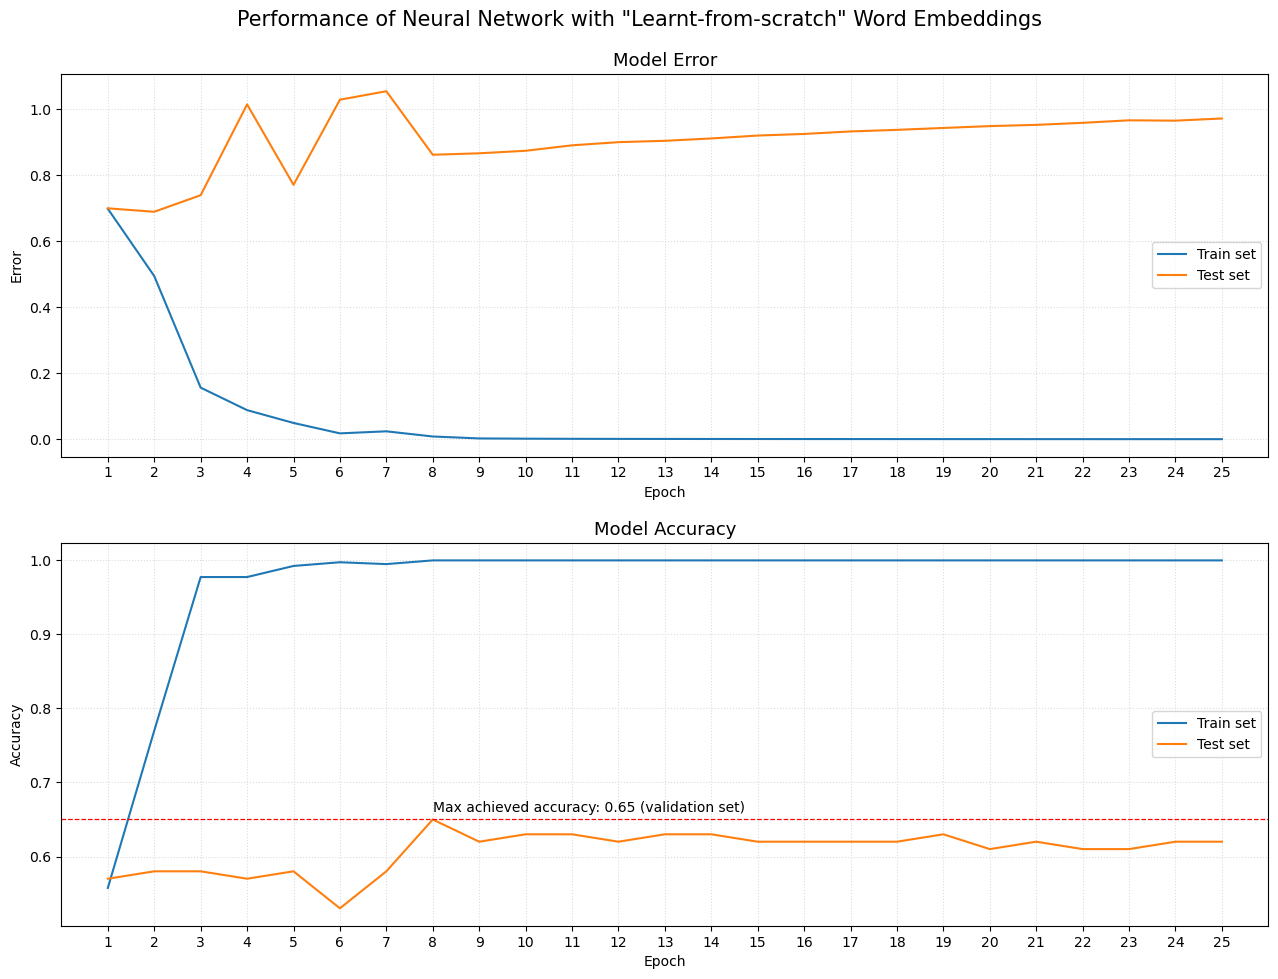

In [77]:
fig = plt.figure(figsize=(13,10))
loss = fig.add_subplot(2,1,1) 
accuracy = fig.add_subplot(2,1,2)

accuracy.plot(hist.history['accuracy'])
accuracy.plot(hist.history['val_accuracy'])
accuracy.set_title('Model Accuracy', fontsize=13)
accuracy.set_ylabel('Accuracy')
accuracy.set_xlabel('Epoch')
accuracy.set_xticks(range(0,25))
accuracy.set_xticklabels(range(1,26))
accuracy.set_xlim(-1,25)
accuracy.legend(['Train set', 'Test set'], loc='center right')
accuracy.grid(True, axis='both', color='gainsboro', ls= ':', linewidth=0.8)
accuracy.axhline(y=0.65, color='r', lw=0.9, ls='--')
accuracy.annotate('Max achieved accuracy: 0.65 (validation set)', xy=(7,0.66))

loss.plot(hist.history['loss'])
loss.plot(hist.history['val_loss'])
loss.set_title('Model Error', fontsize=13)
loss.set_ylabel('Error')
loss.set_xlabel('Epoch')
loss.set_xticks(range(0,25))
loss.set_xticklabels(range(1,26))
loss.set_xlim(-1,25)
loss.legend(['Train set', 'Test set'], loc='center right')
loss.grid(True, axis='both', color='gainsboro', ls= ':', linewidth=0.8)

plt.suptitle('Performance of Neural Network with "Learnt-from-scratch" Word Embeddings', fontsize=15)
plt.tight_layout(pad=1.5)
plt.show()

Some remarks:
- The model manages to perfectly fit the training data after 8 epochs, achieving an accuracy of 100% and a loss next to 0.
- The validation loss fluctuates for the first 8 epochs, after which it keeps increasing in each epoch. **This is a clear sign of overfitting.**
- The accuracy, on the validation set, reaches the geatest value (65%) at the 8th epoch, after which it stays stable around 61% - 63%. **There's no further gain in keeping training the model after 8 epocs.**
- I'll load the weights that achieved the best validation accuracy (saved with the Keras "Model Check Point" callback) and output the model predictions.

In [78]:
rnn.load_weights('rnn_best_weights.hdf5')
print("Best Accuracy achieved on validation data:", round(rnn.evaluate(x_test_pad, y_test)[1],2))

4/4 [==============================] - 0s 20ms/step - loss: 0.8611 - accuracy: 0.6500
Best Accuracy achieved on validation data: 0.65


In [80]:
ypred = rnn.predict(x_test_pad)
ypred[0:5]

4/4 [==============================] - 0s 25ms/step


array([[0.7714262 ],
       [0.90516   ],
       [0.34231988],
       [0.89127713],
       [0.9844603 ]], dtype=float32)

---

*Since I have problems seeding (to get reproducible results) more than 1 Keras network in the same notebook, I'll export both the training and testing sets, the vocabulary word index from the Tokenizer, and the model's predictions in my working directory, and I'll re-import the data in another notebook, where I can develop (and successfully seed) the second model.*

In [81]:
#export the training sets
pd.DataFrame(x_train_pad).to_csv('x_train_pad.csv', index=False)
y_train.to_csv('y_train.csv', index=False)

#export the testing sets
pd.DataFrame(x_test_pad).to_csv('x_test_pad.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

In [82]:
#export the training word index
import pickle
with open('word_index.pkl', 'wb') as f:
    pickle.dump(tokenizer.word_index, f)

In [83]:
#export the predictions
import pickle
with open('ypred.pkl', 'wb') as f:
    pickle.dump(ypred, f)

## End of part 1